In [1]:
import SimpleITK as sitk
import numpy as np
from pathlib import Path
from PIL import Image
import os
import pandas as pd
from radiomics import featureextractor

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# import gui
import ipywidgets as widgets
from IPython.display import display


In [2]:
def loadDcm(dcm_path: Path):
    """
    load dicom files from dcm_path(folder), return (ndarray, sitk.Image)
    """
    # 使用SimpleITK读取DICOM文件夹
    series_reader = sitk.ImageSeriesReader()
    series_reader.MetaDataDictionaryArrayUpdateOn()
    series_reader.LoadPrivateTagsOn()
    dicom_series = series_reader.GetGDCMSeriesFileNames(str(dcm_path))
    series_reader.SetFileNames(dicom_series)
    ct_image = series_reader.Execute()

    # 将SimpleITK图像转换为NumPy数组
    ct_ndarray = sitk.GetArrayFromImage(ct_image)

    return ct_ndarray, ct_image

In [3]:
def laodMask(mask_path: Path):
    """
    load png files from mask_path(folder), return (ndarray)
    """

    # 获取文件夹中所有PNG文件的文件名
    mask_path = str(mask_path)
    png_files = sorted([f for f in os.listdir(mask_path) if f.endswith(".png")])

    # 通过循环读取PNG文件序列并存储在列表中
    mask_sequence = []
    for png_file in png_files:
        png_path = os.path.join(mask_path, png_file)
        image = Image.open(png_path)
        mask_sequence.append(image)

    masks = np.stack([np.array(image) for image in mask_sequence[::-1]])
    return masks

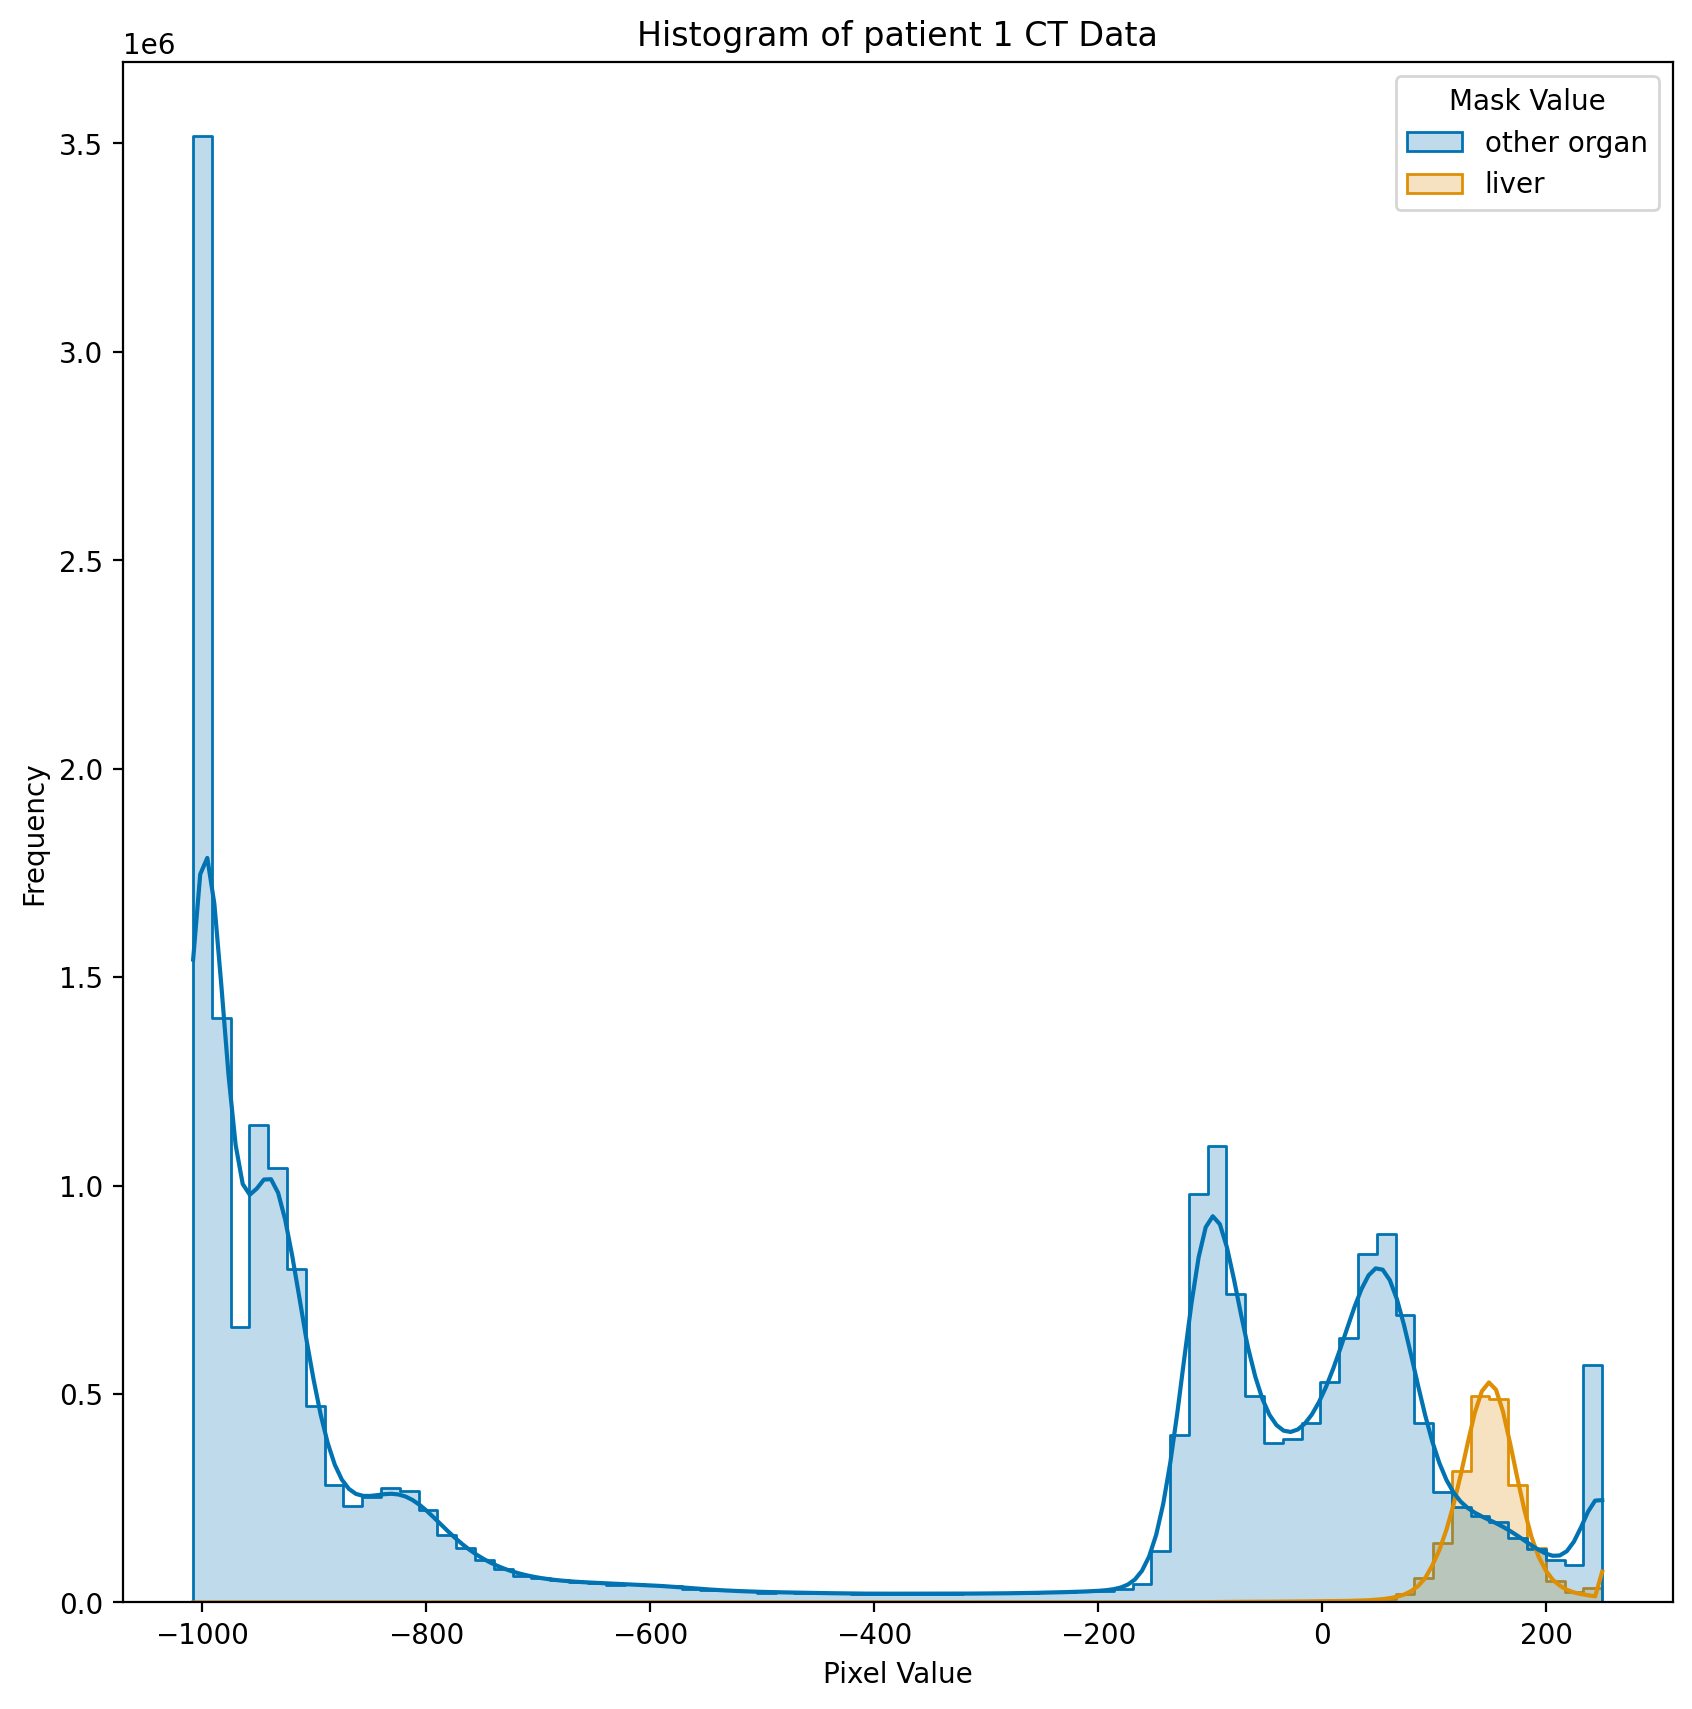

Mean:  -415.9623115460078
Median:  -121.0
Max:  250.0
Min:  -1008.0


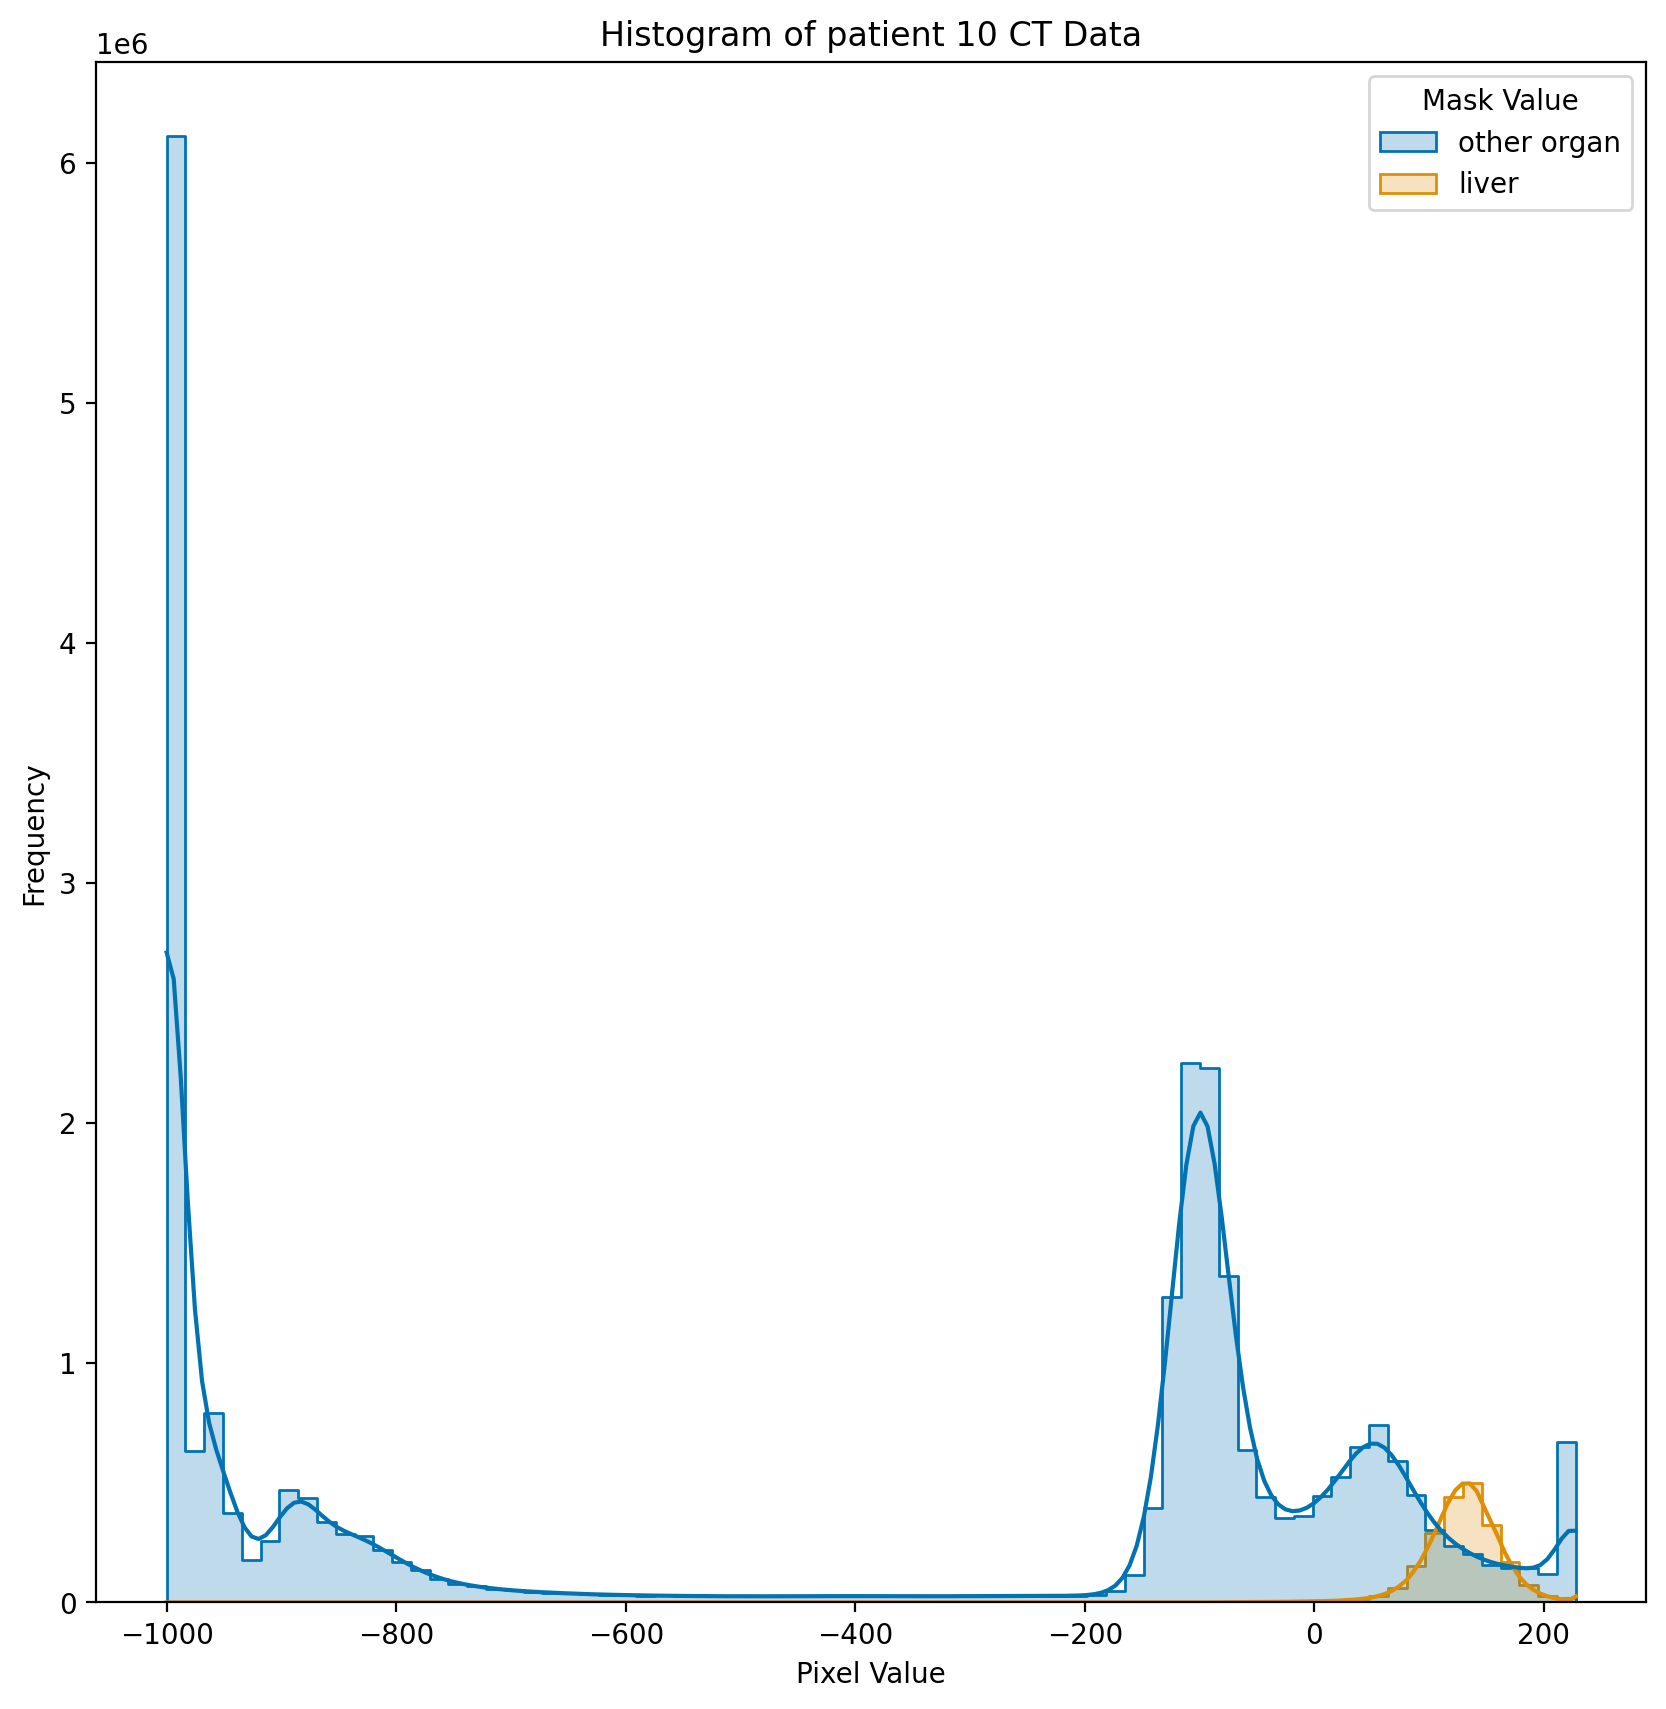

Mean:  -379.4038795471191
Median:  -110.0
Max:  228.0
Min:  -1000.0


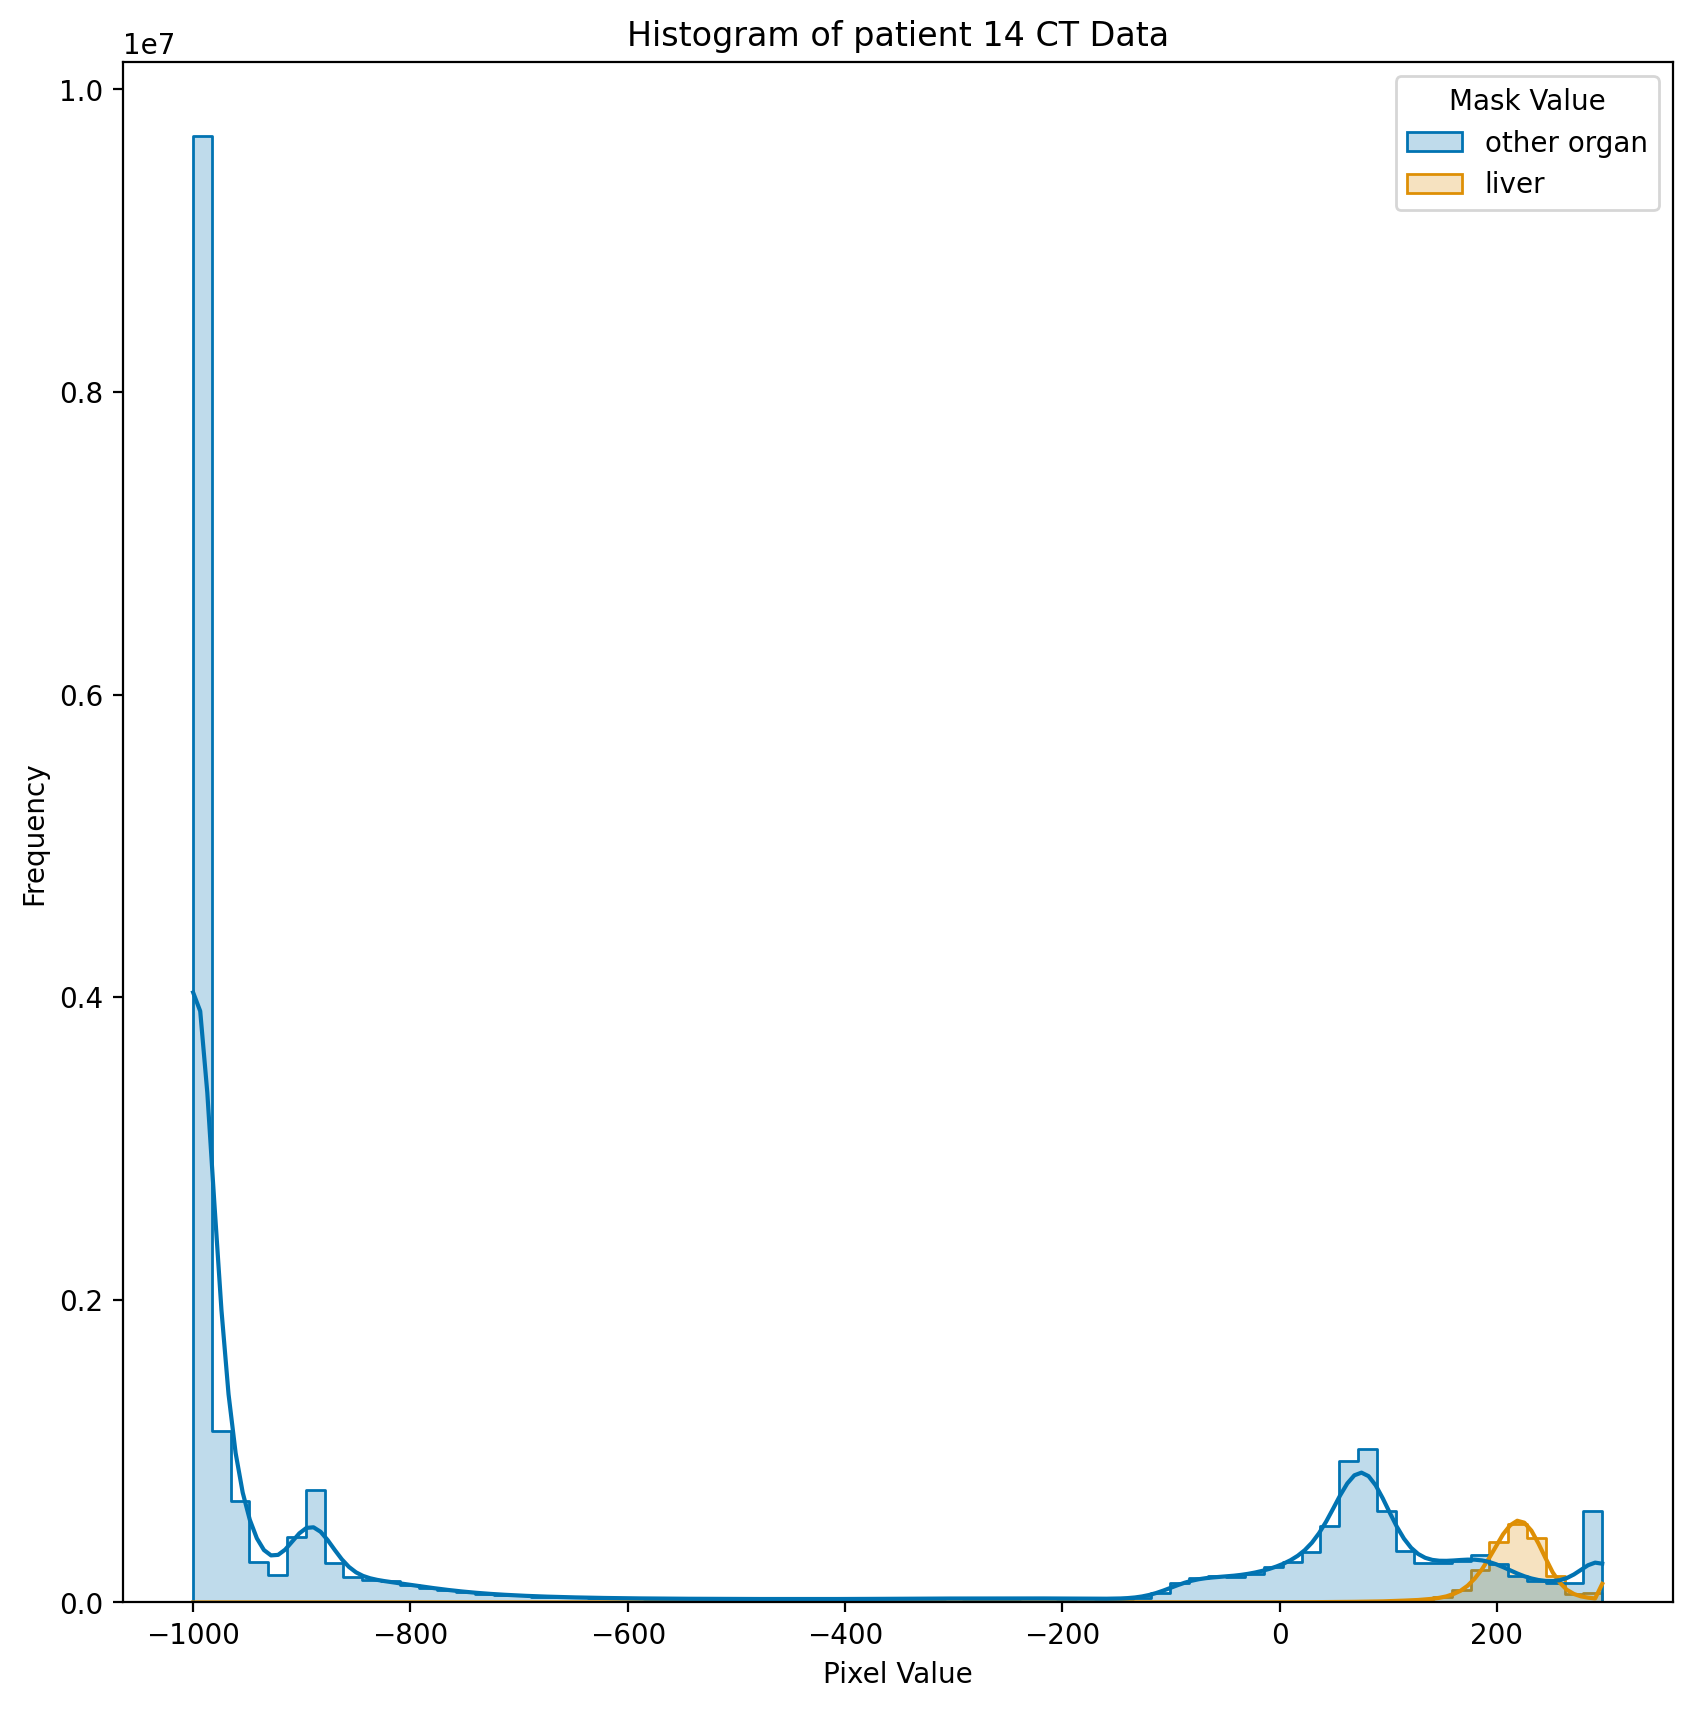

Mean:  -524.1872409218236
Median:  -895.0
Max:  297.0
Min:  -1000.0


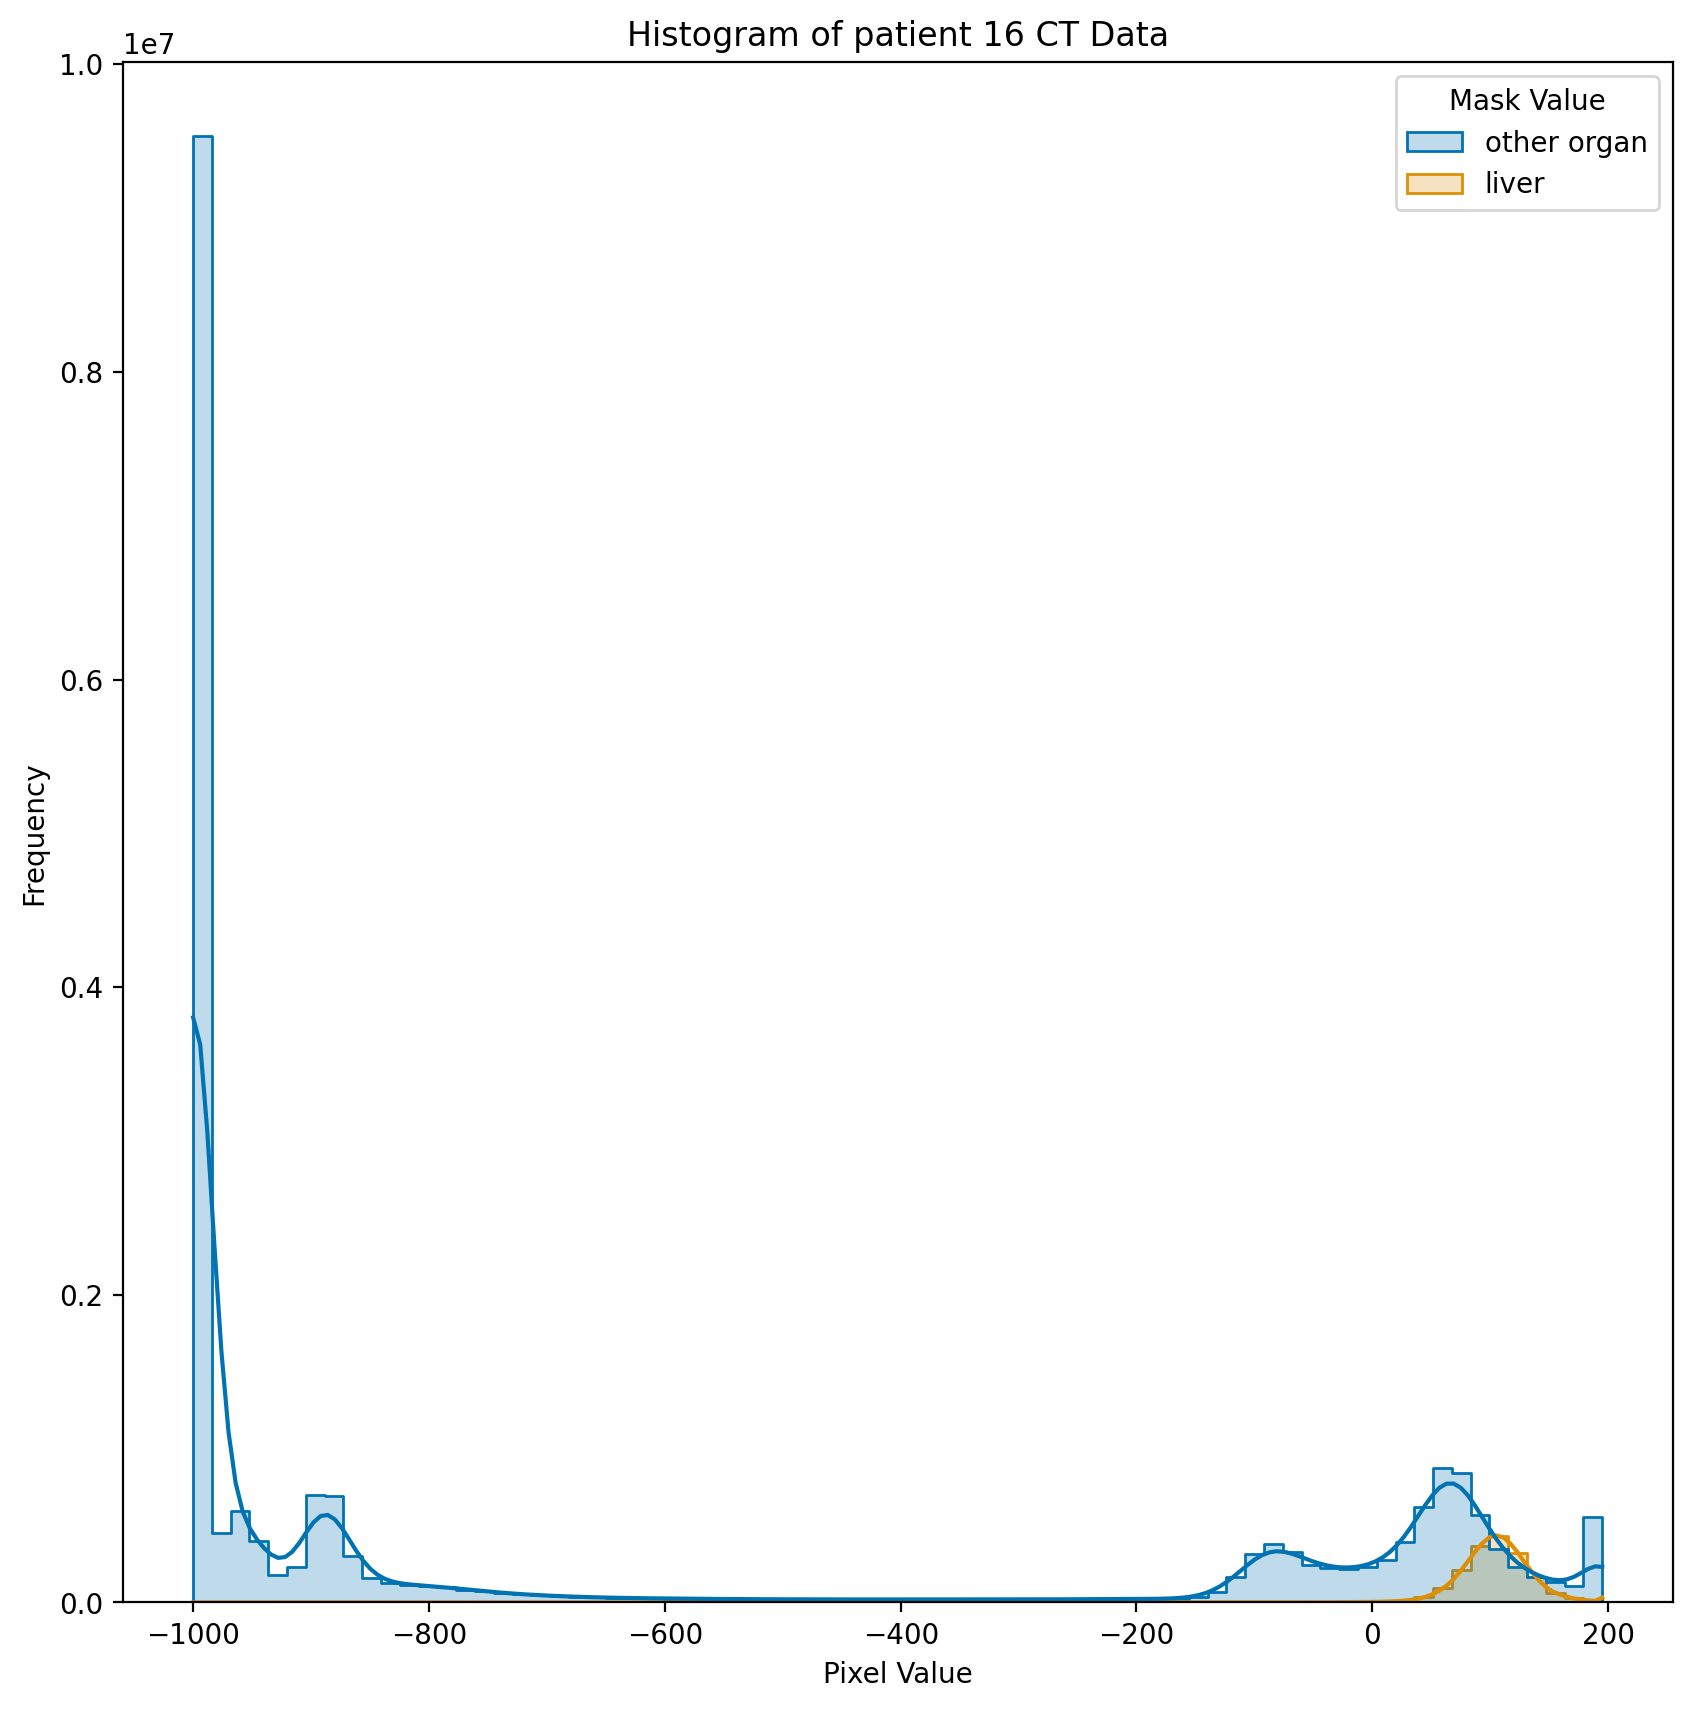

Mean:  -561.2440677265545
Median:  -891.0
Max:  195.0
Min:  -1000.0


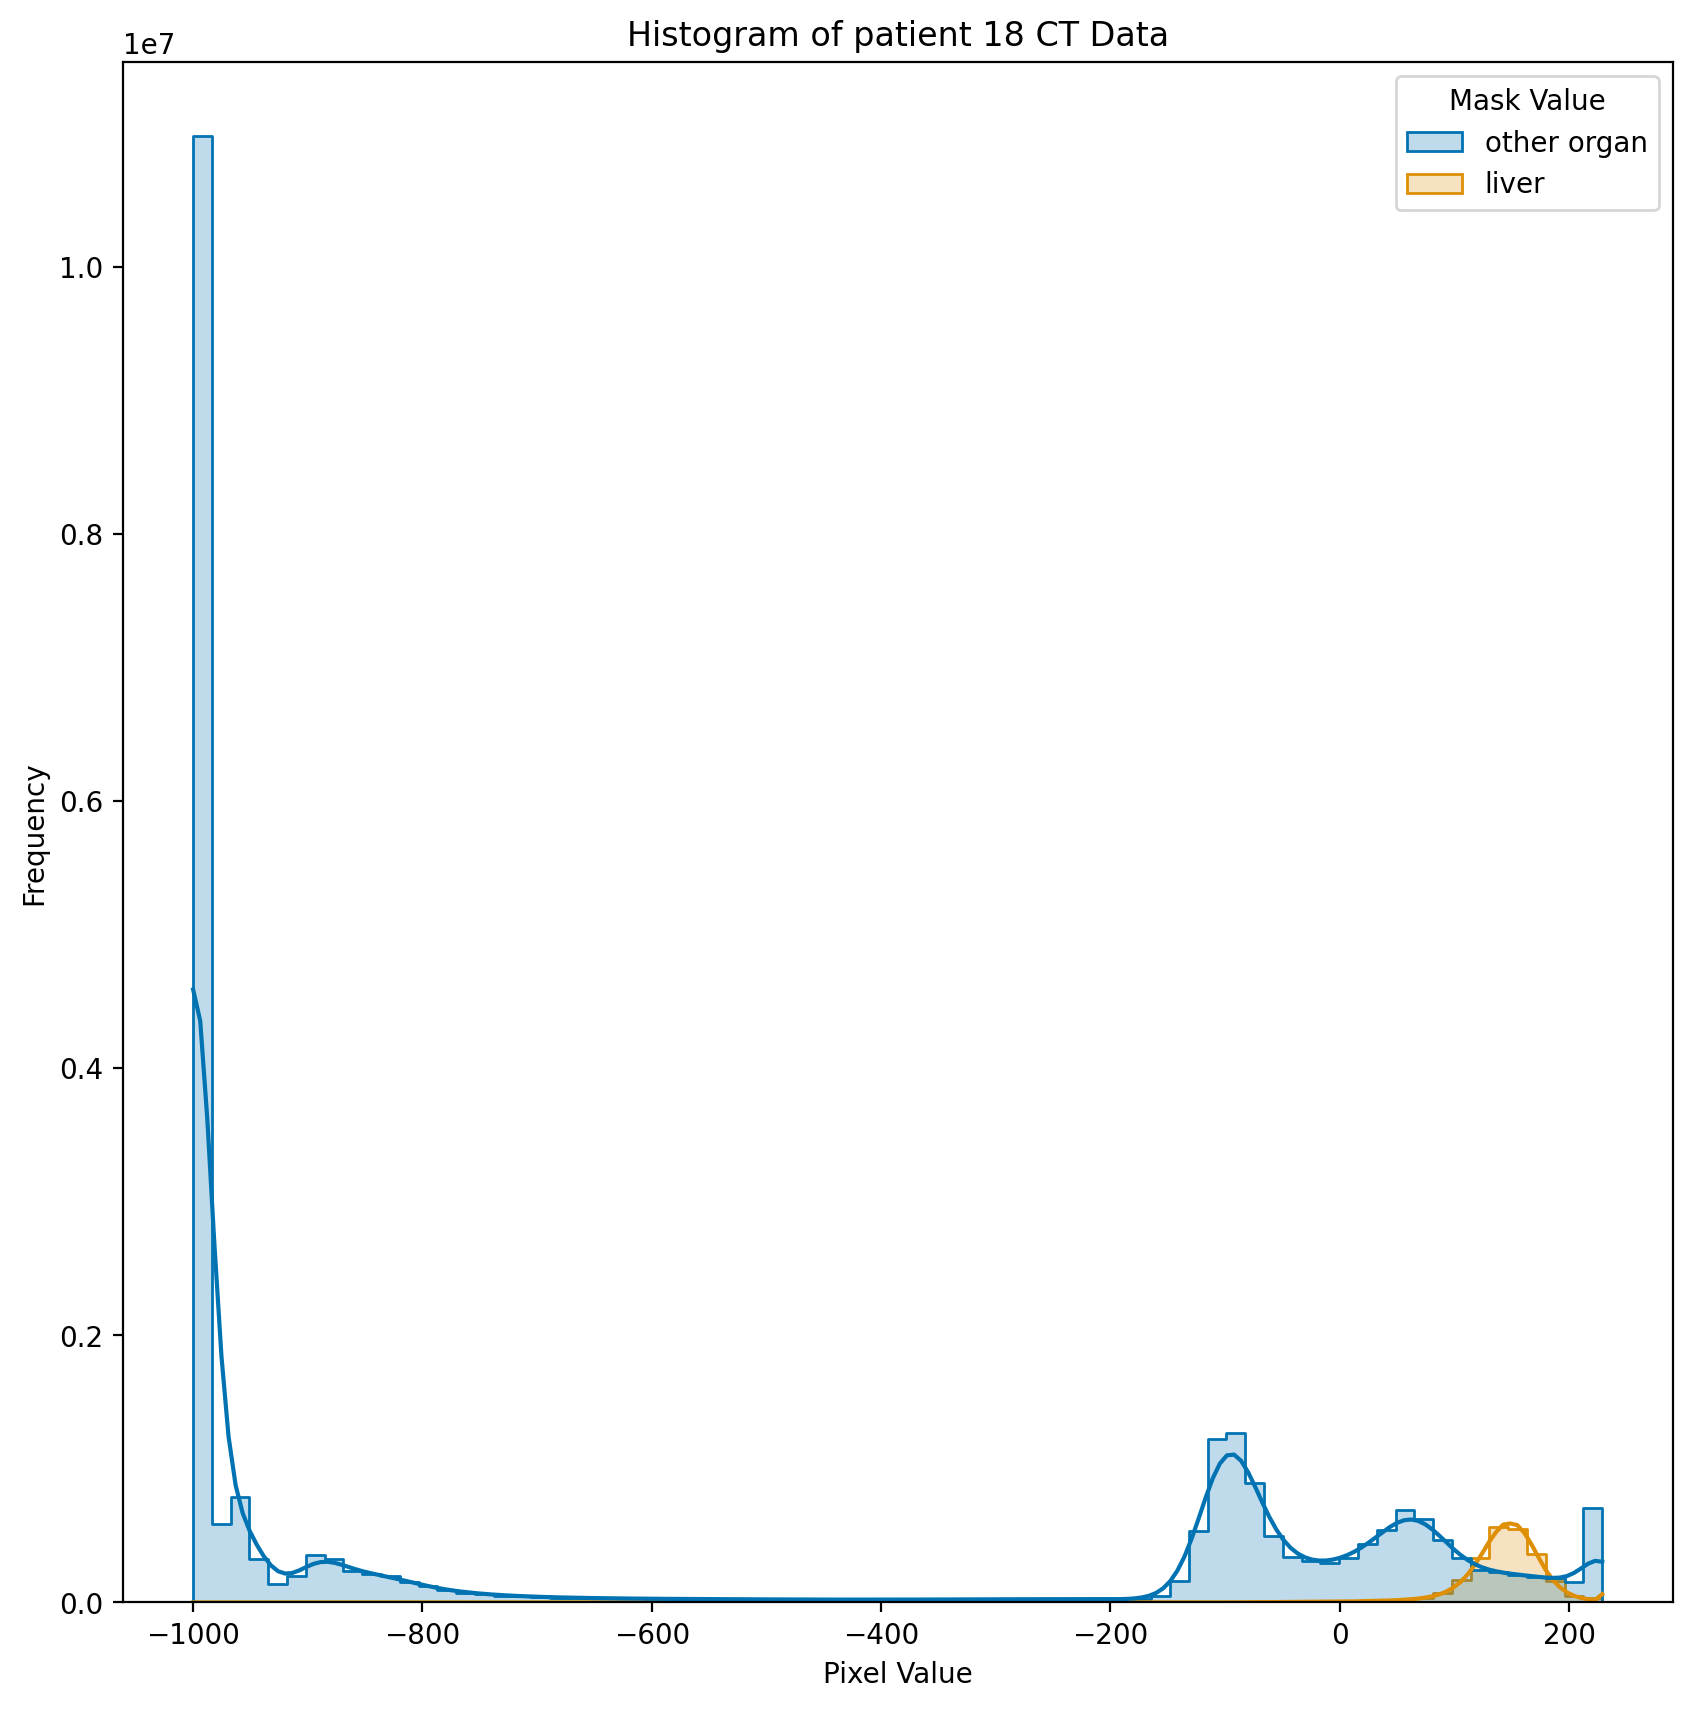

Mean:  -497.5749402432828
Median:  -796.0
Max:  229.0
Min:  -1000.0


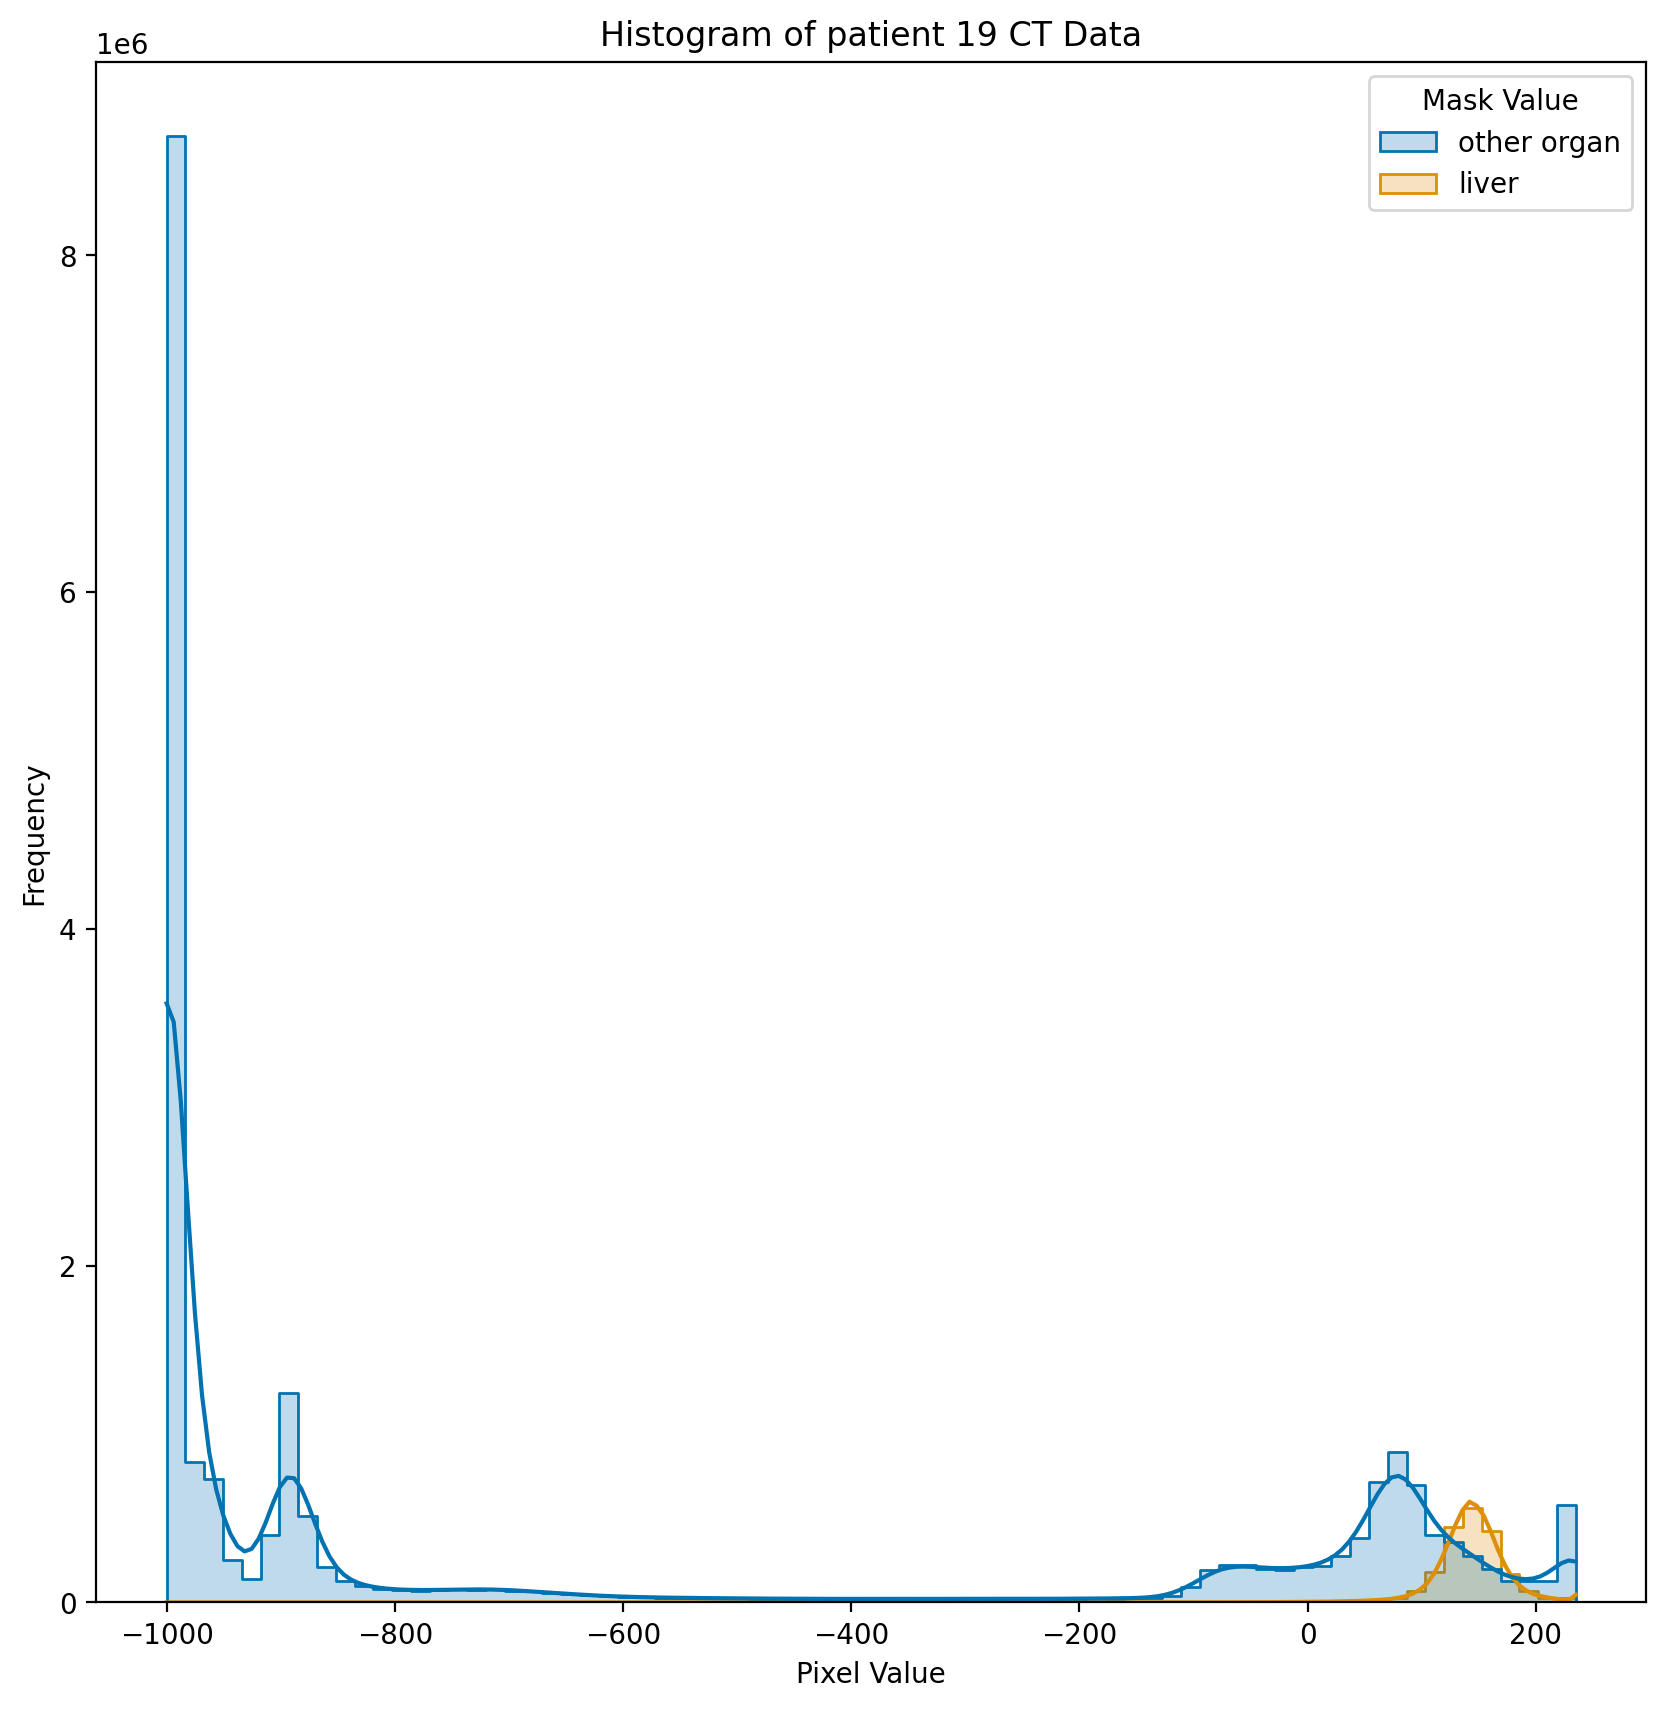

Mean:  -549.0420731014675
Median:  -892.0
Max:  235.0
Min:  -1000.0


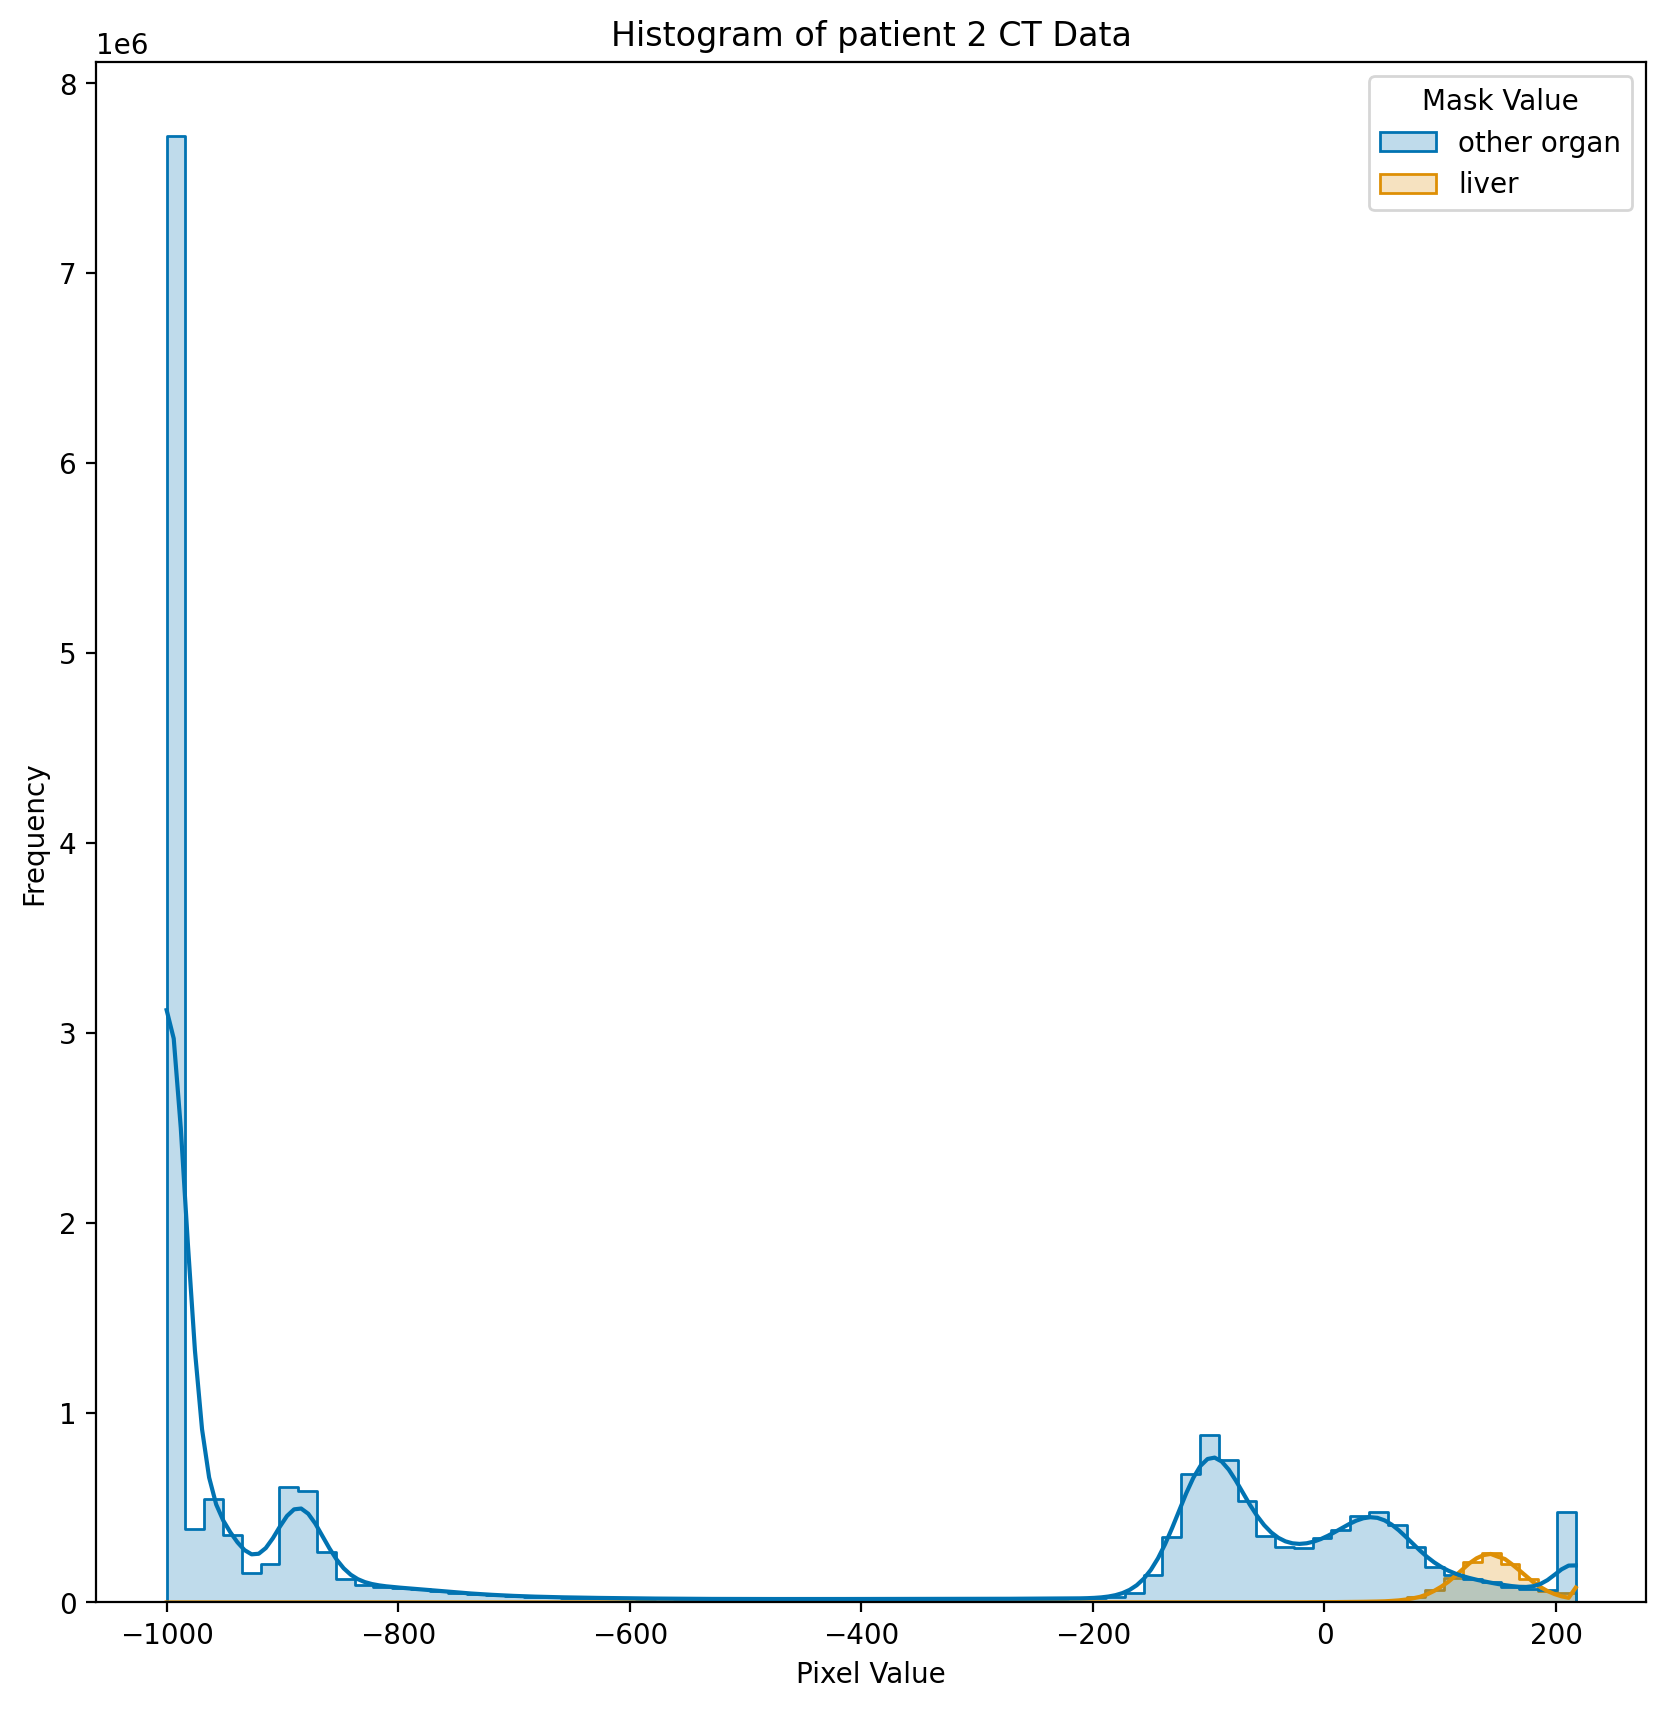

Mean:  -532.5184568711269
Median:  -868.0
Max:  217.0
Min:  -1000.0


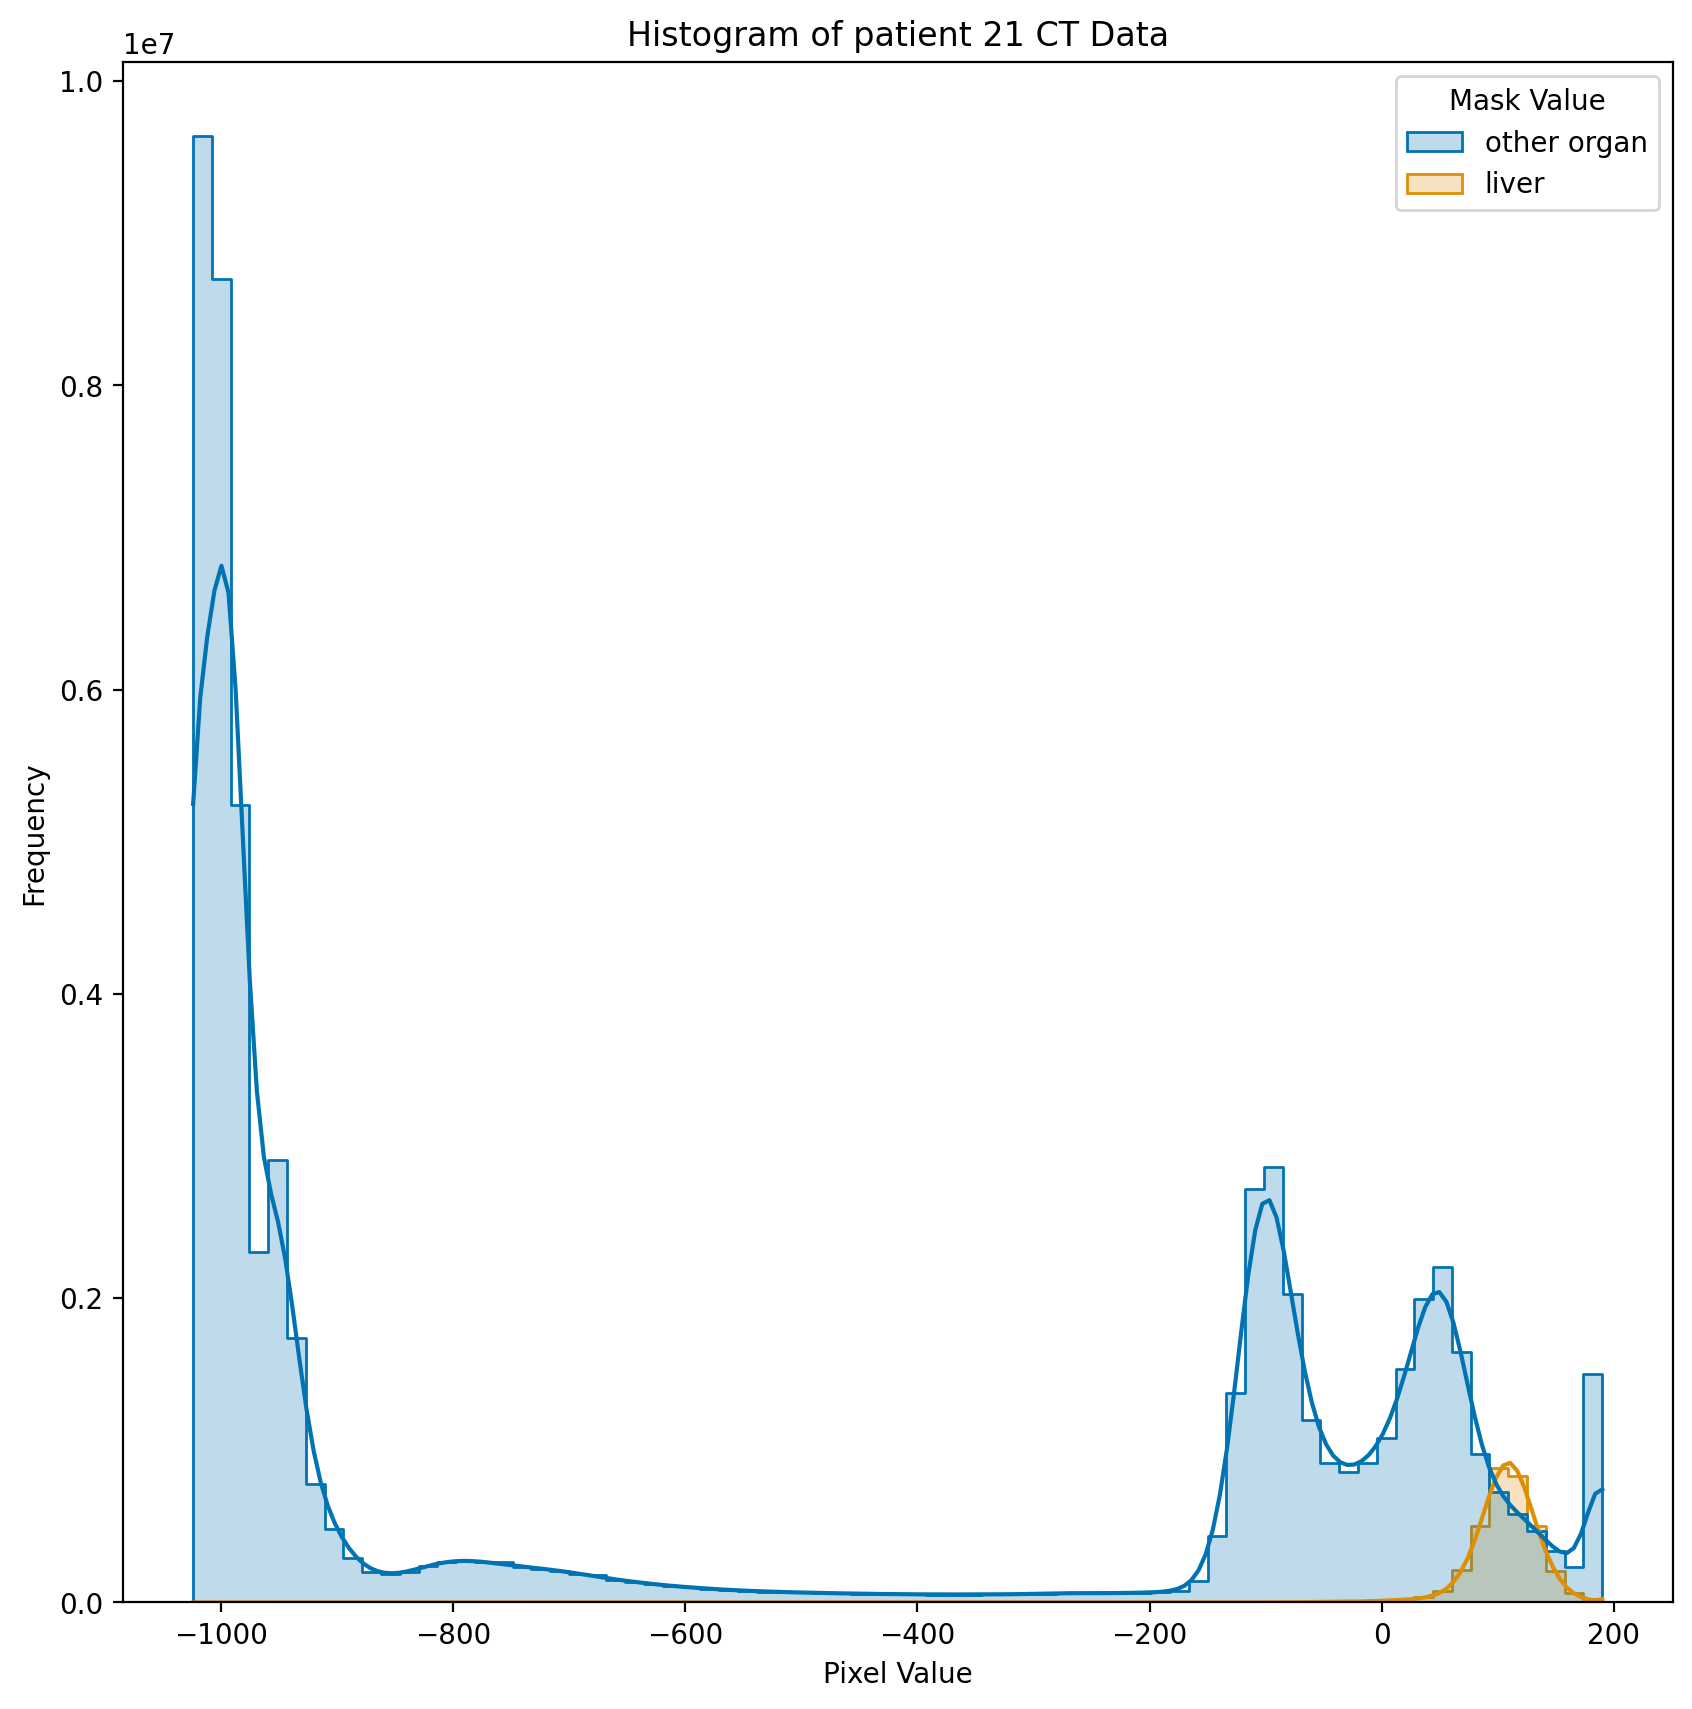

Mean:  -516.2660872463123
Median:  -768.0
Max:  190.0
Min:  -1024.0


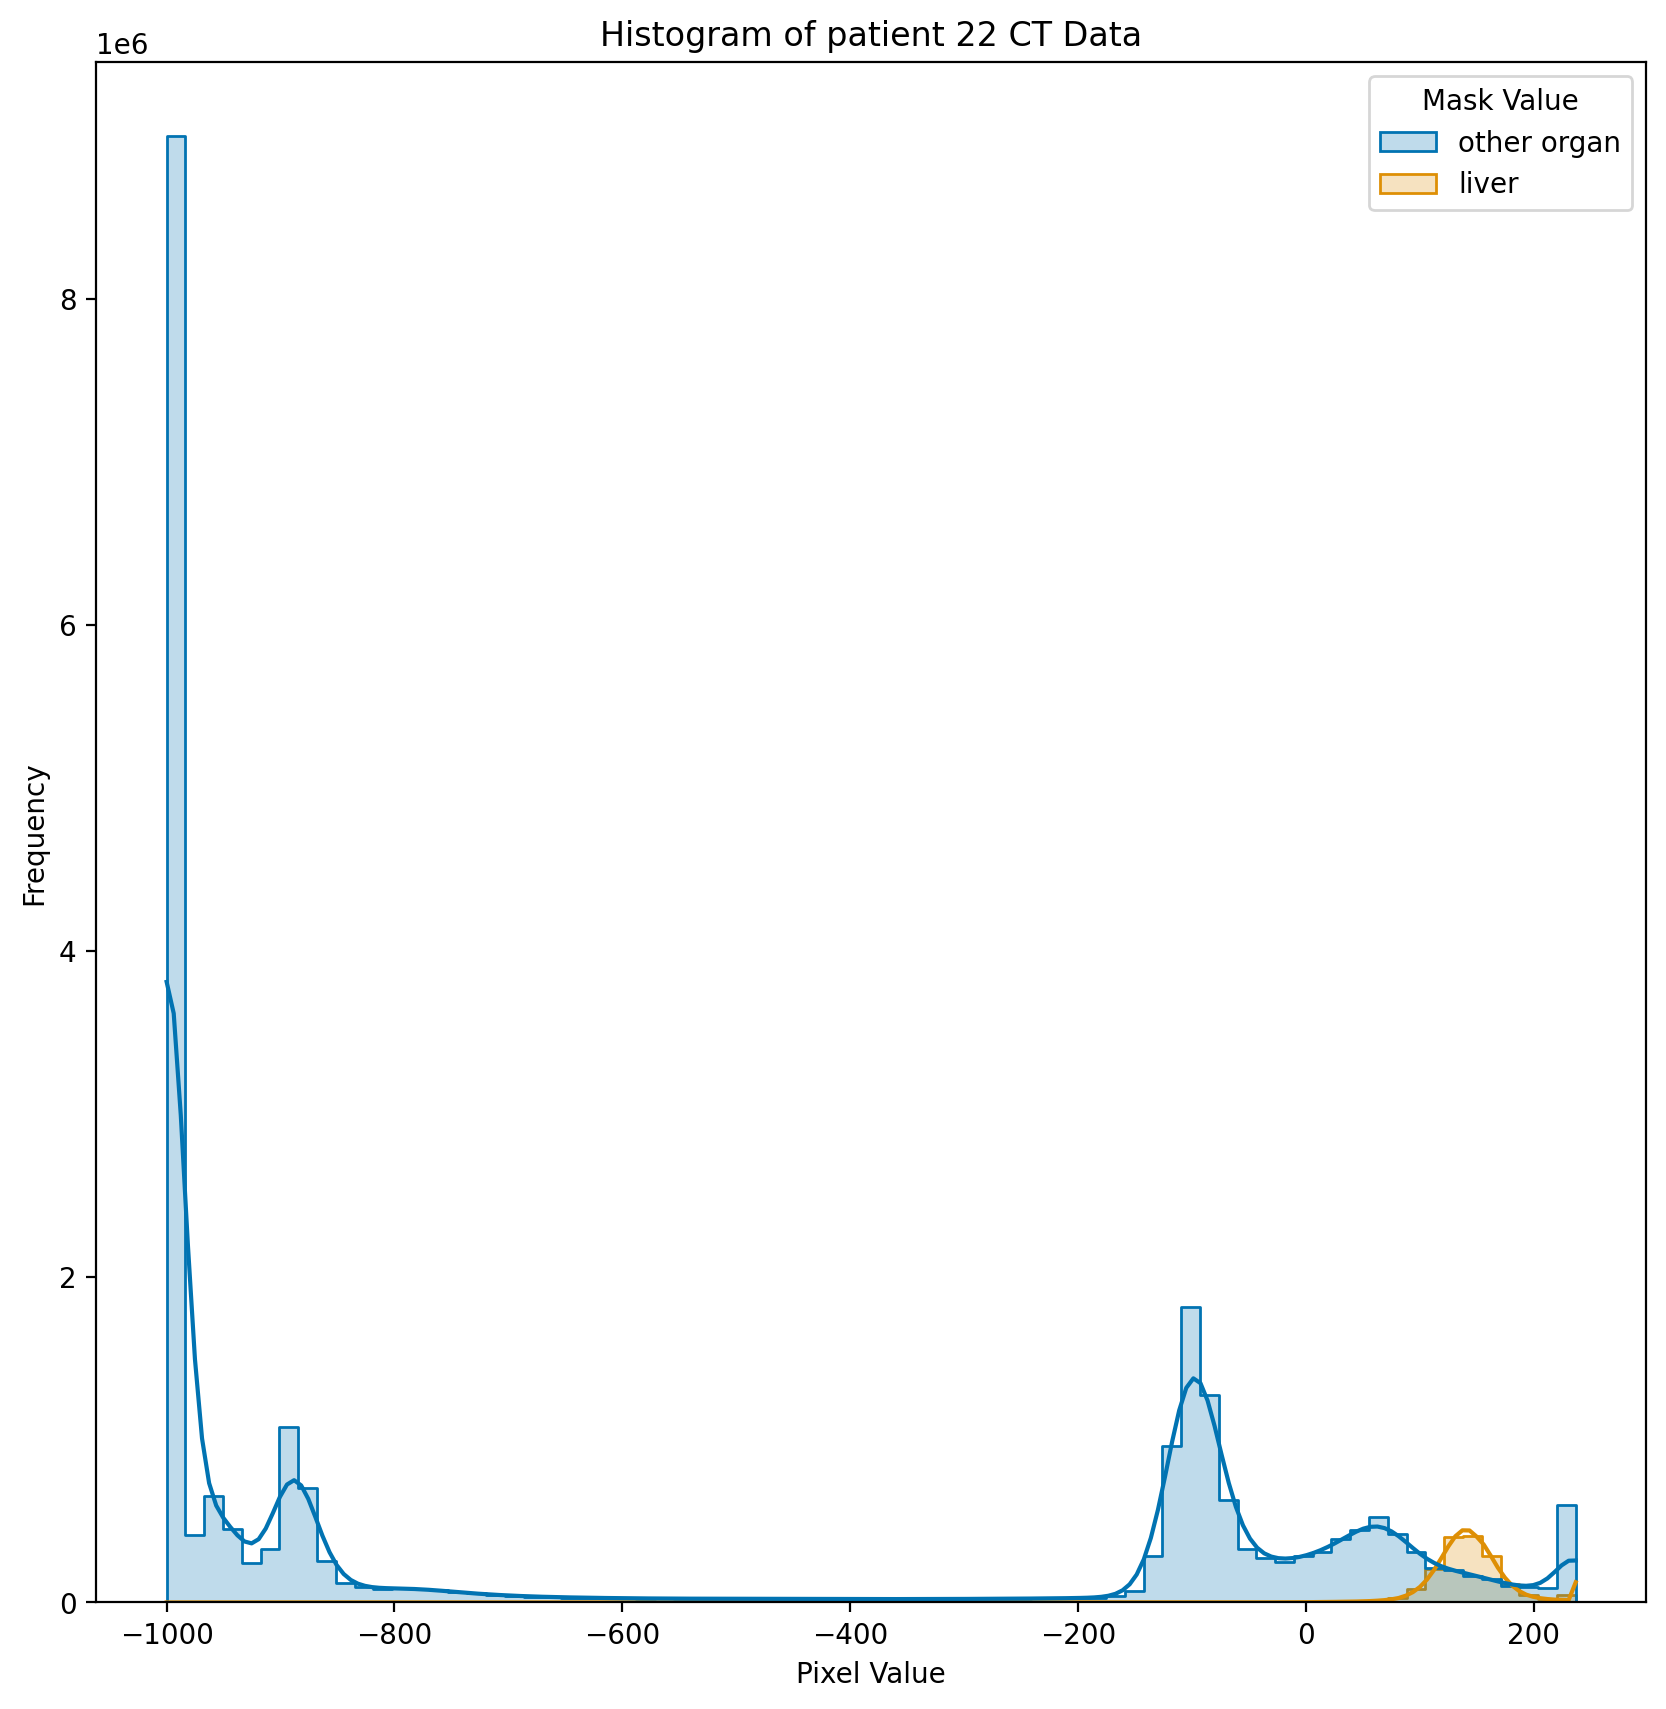

Mean:  -511.48490048399066
Median:  -835.0
Max:  237.0
Min:  -1000.0


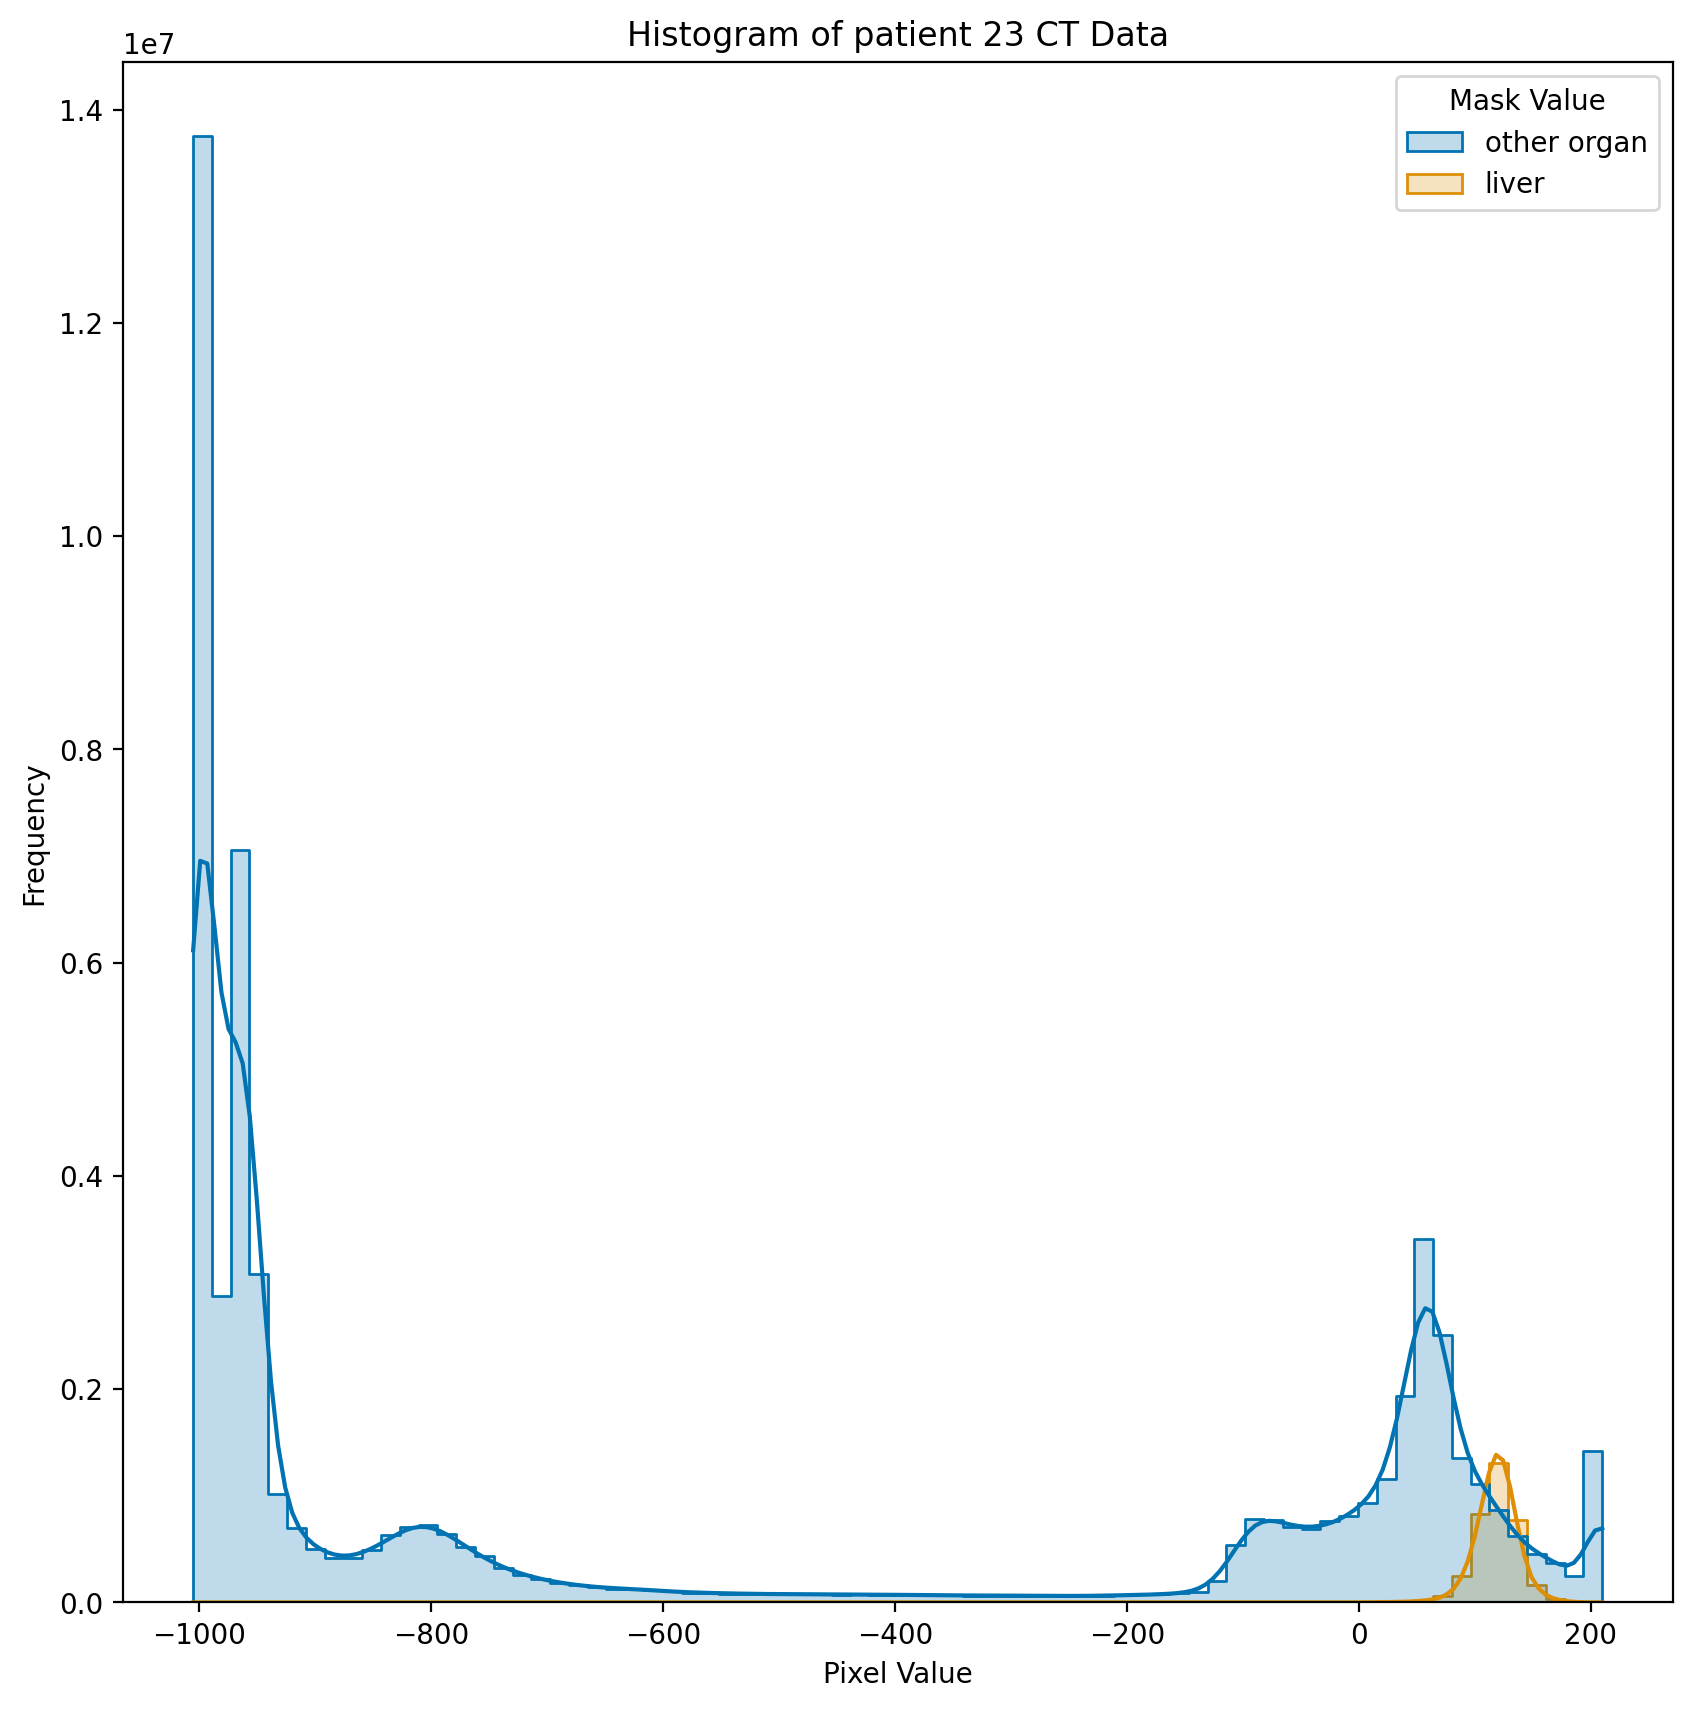

Mean:  -522.3067410310109
Median:  -815.0
Max:  210.0
Min:  -1005.0


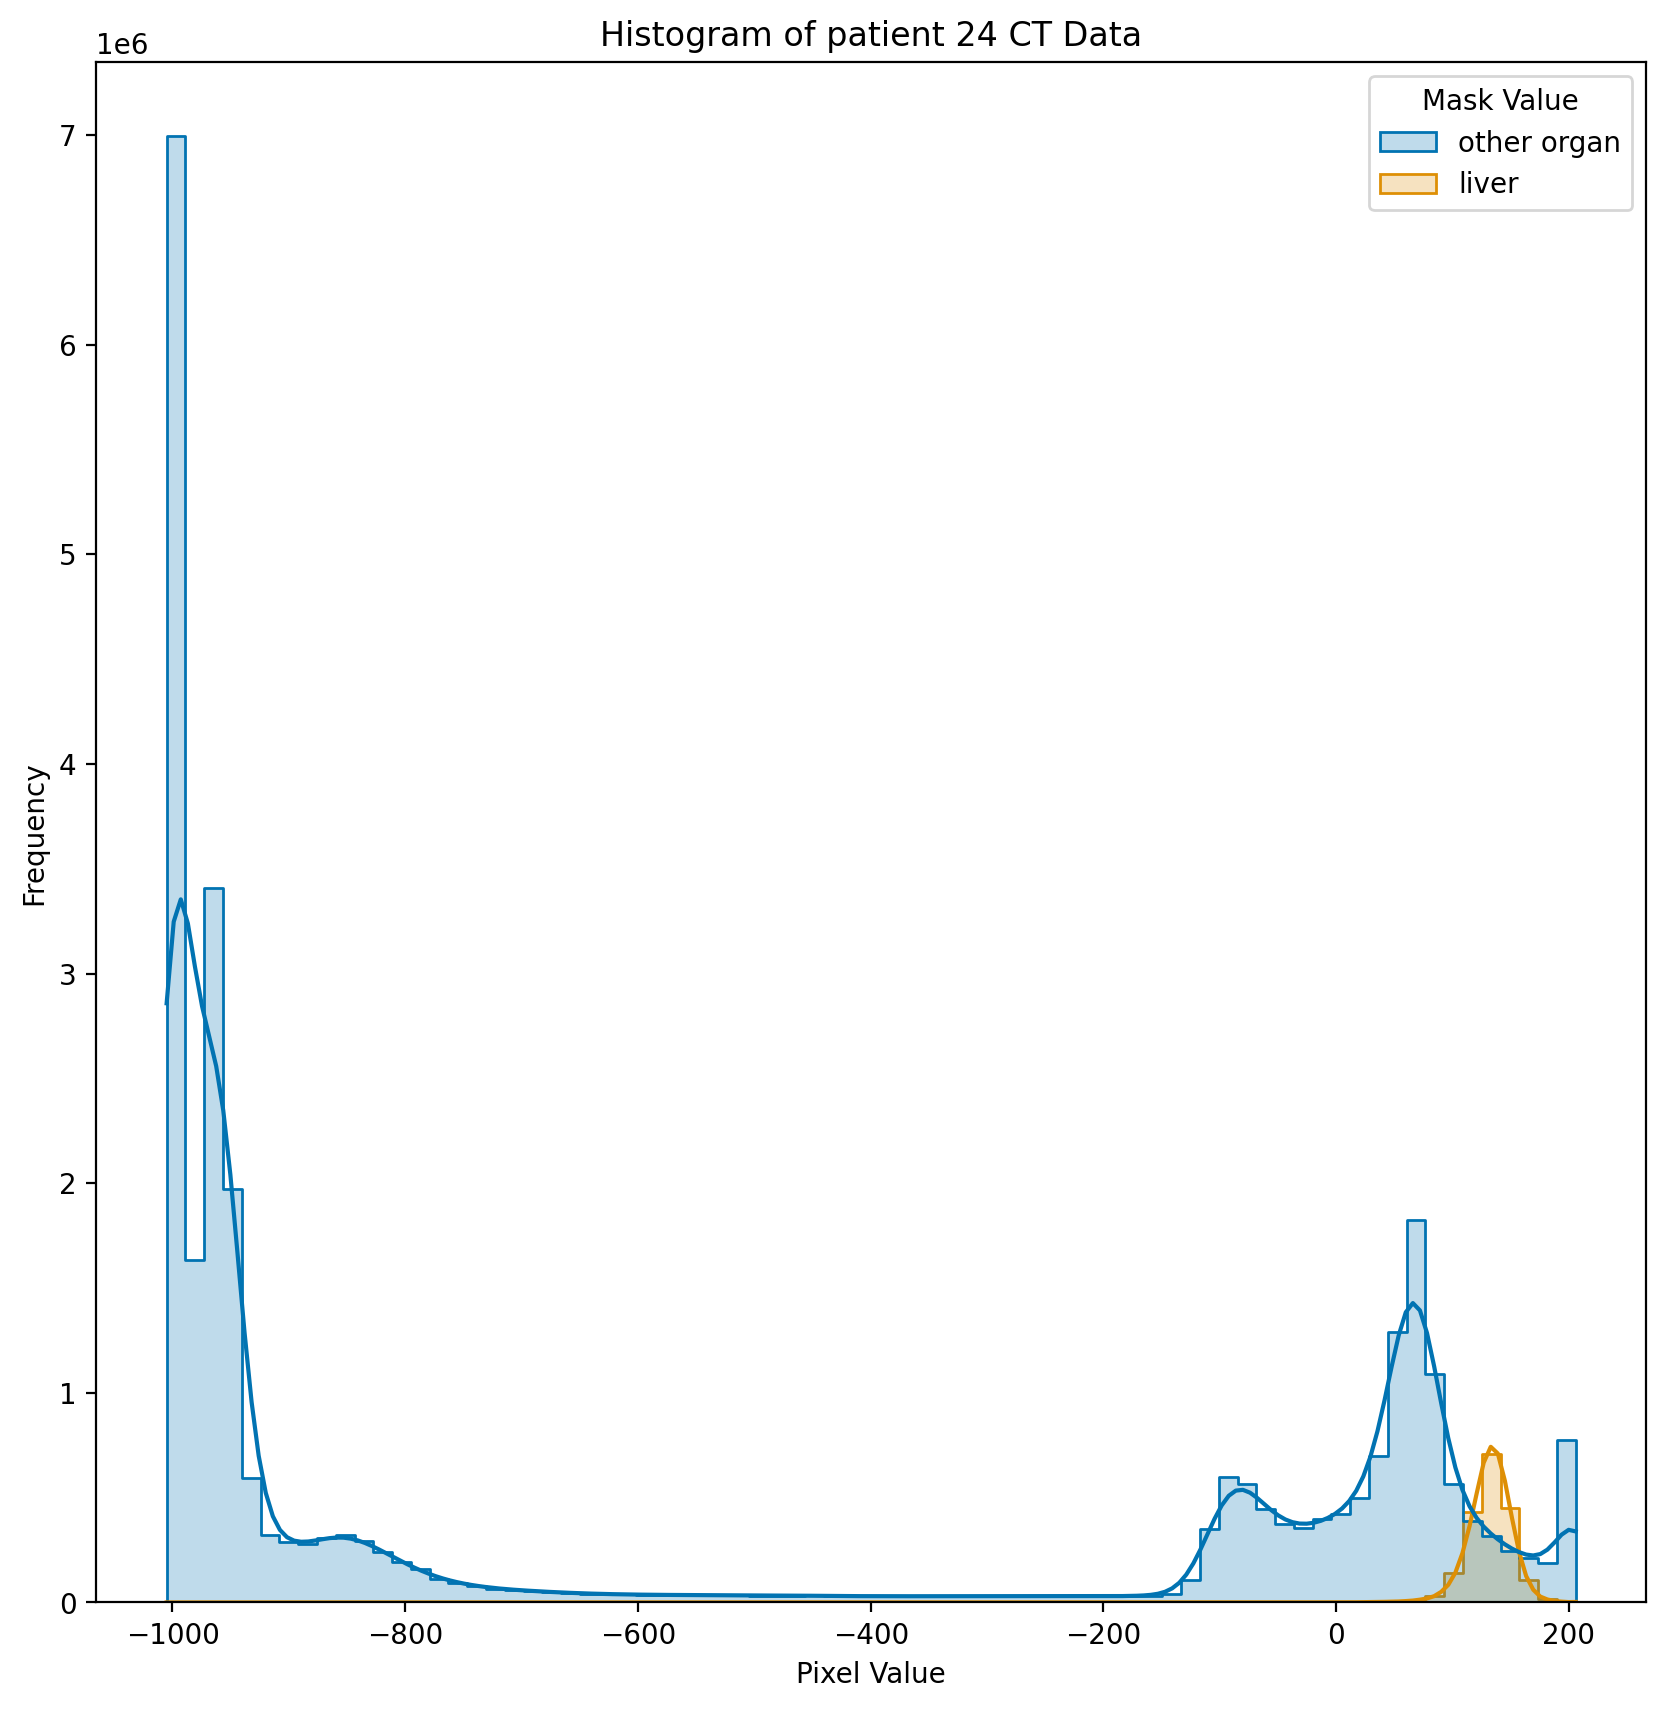

Mean:  -509.269008419378
Median:  -844.0
Max:  206.0
Min:  -1005.0


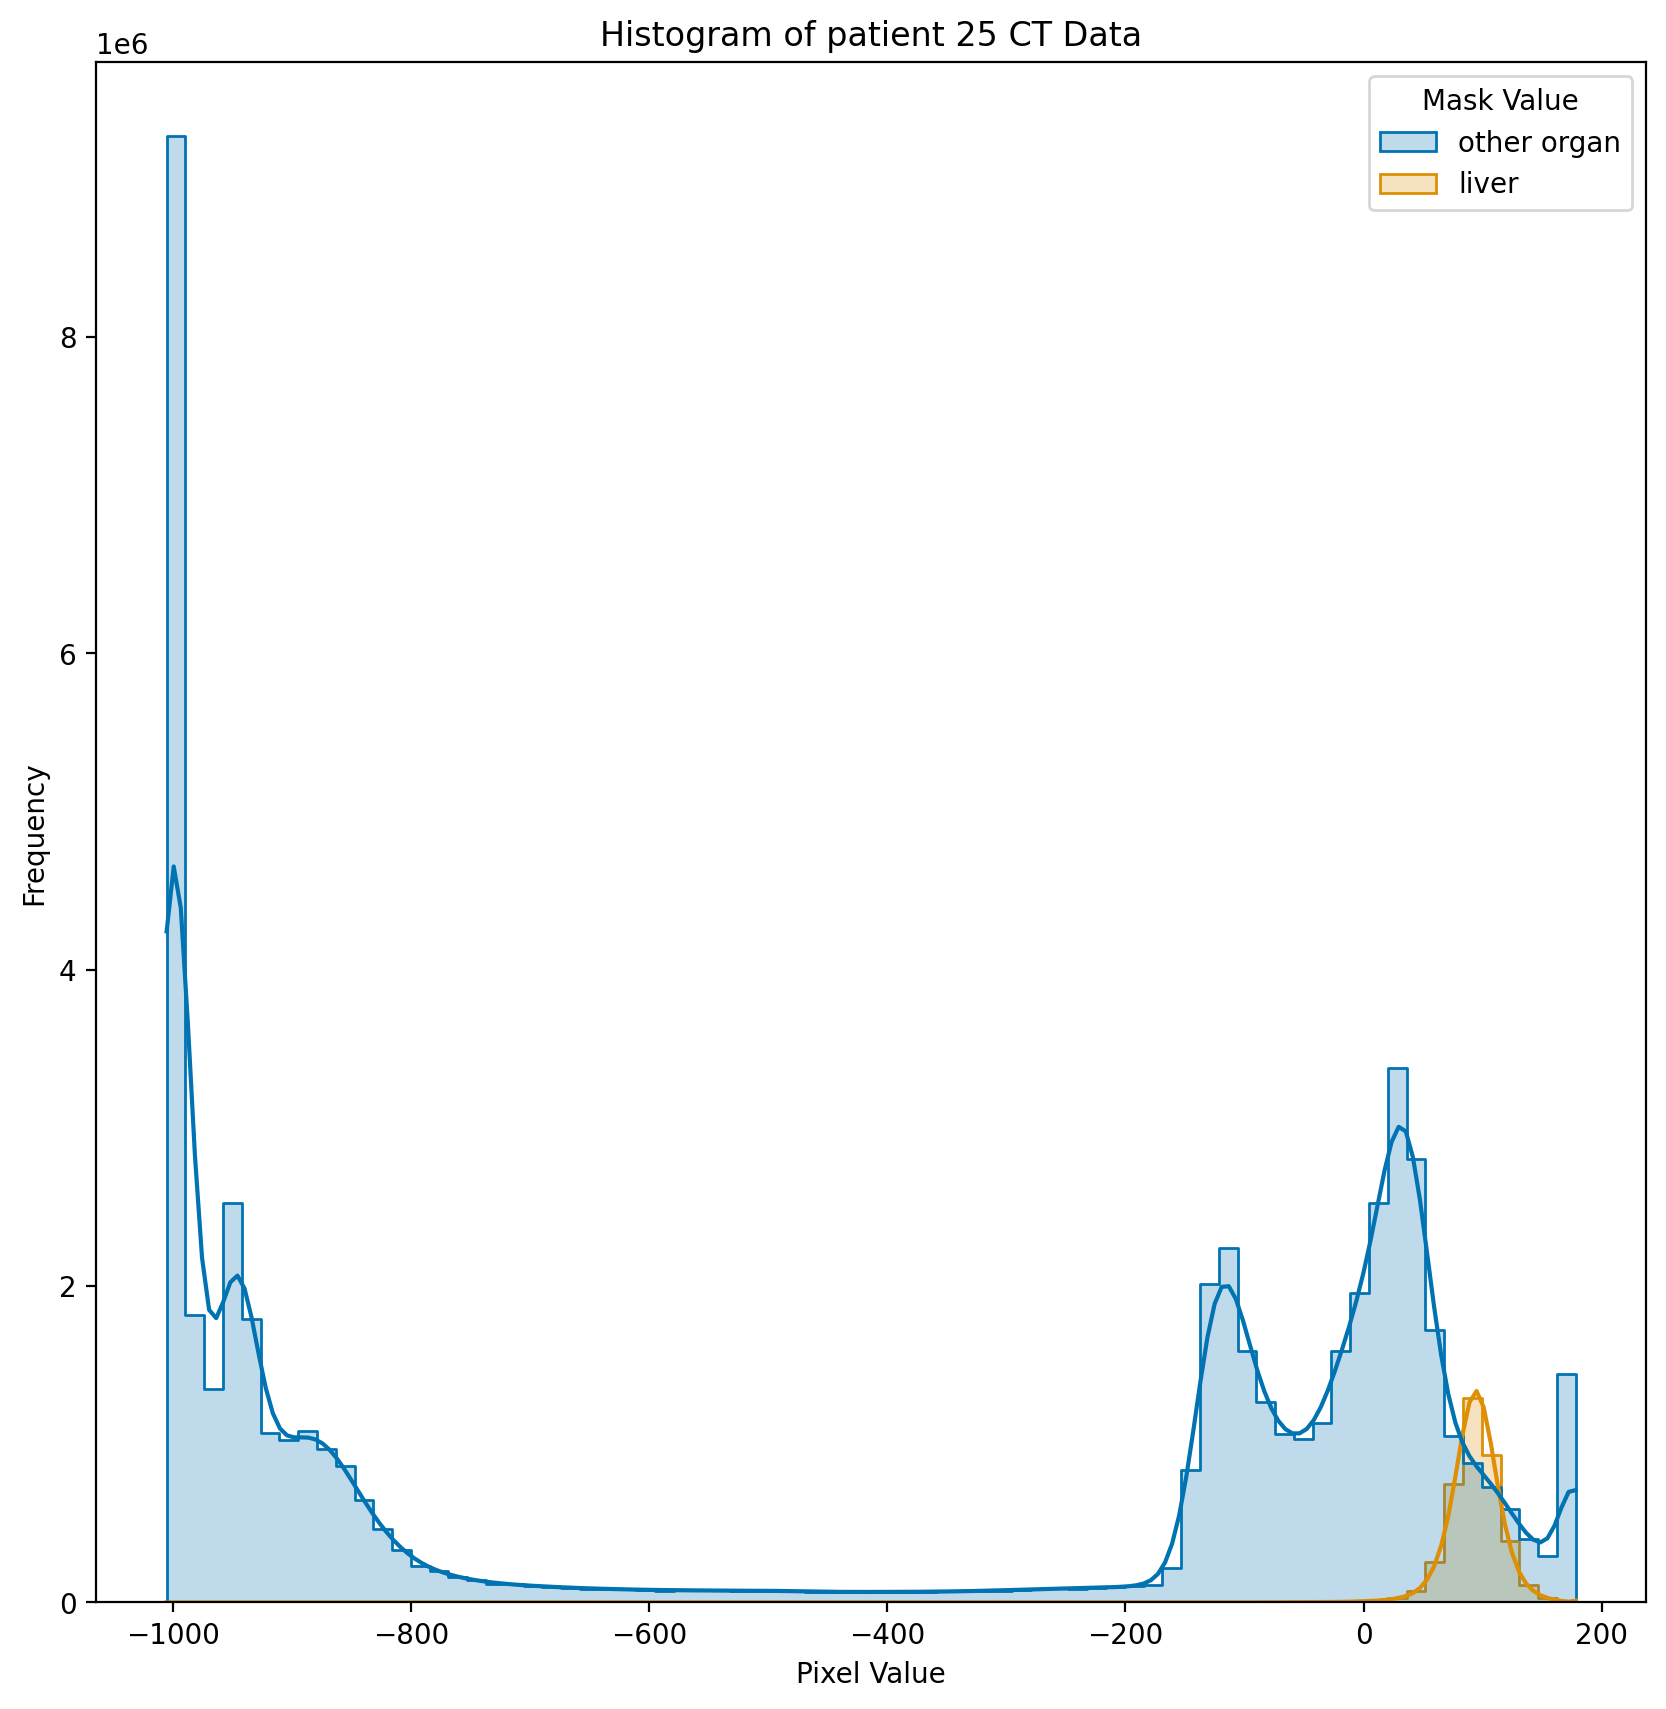

Mean:  -385.782328910016
Median:  -116.0
Max:  178.0
Min:  -1005.0


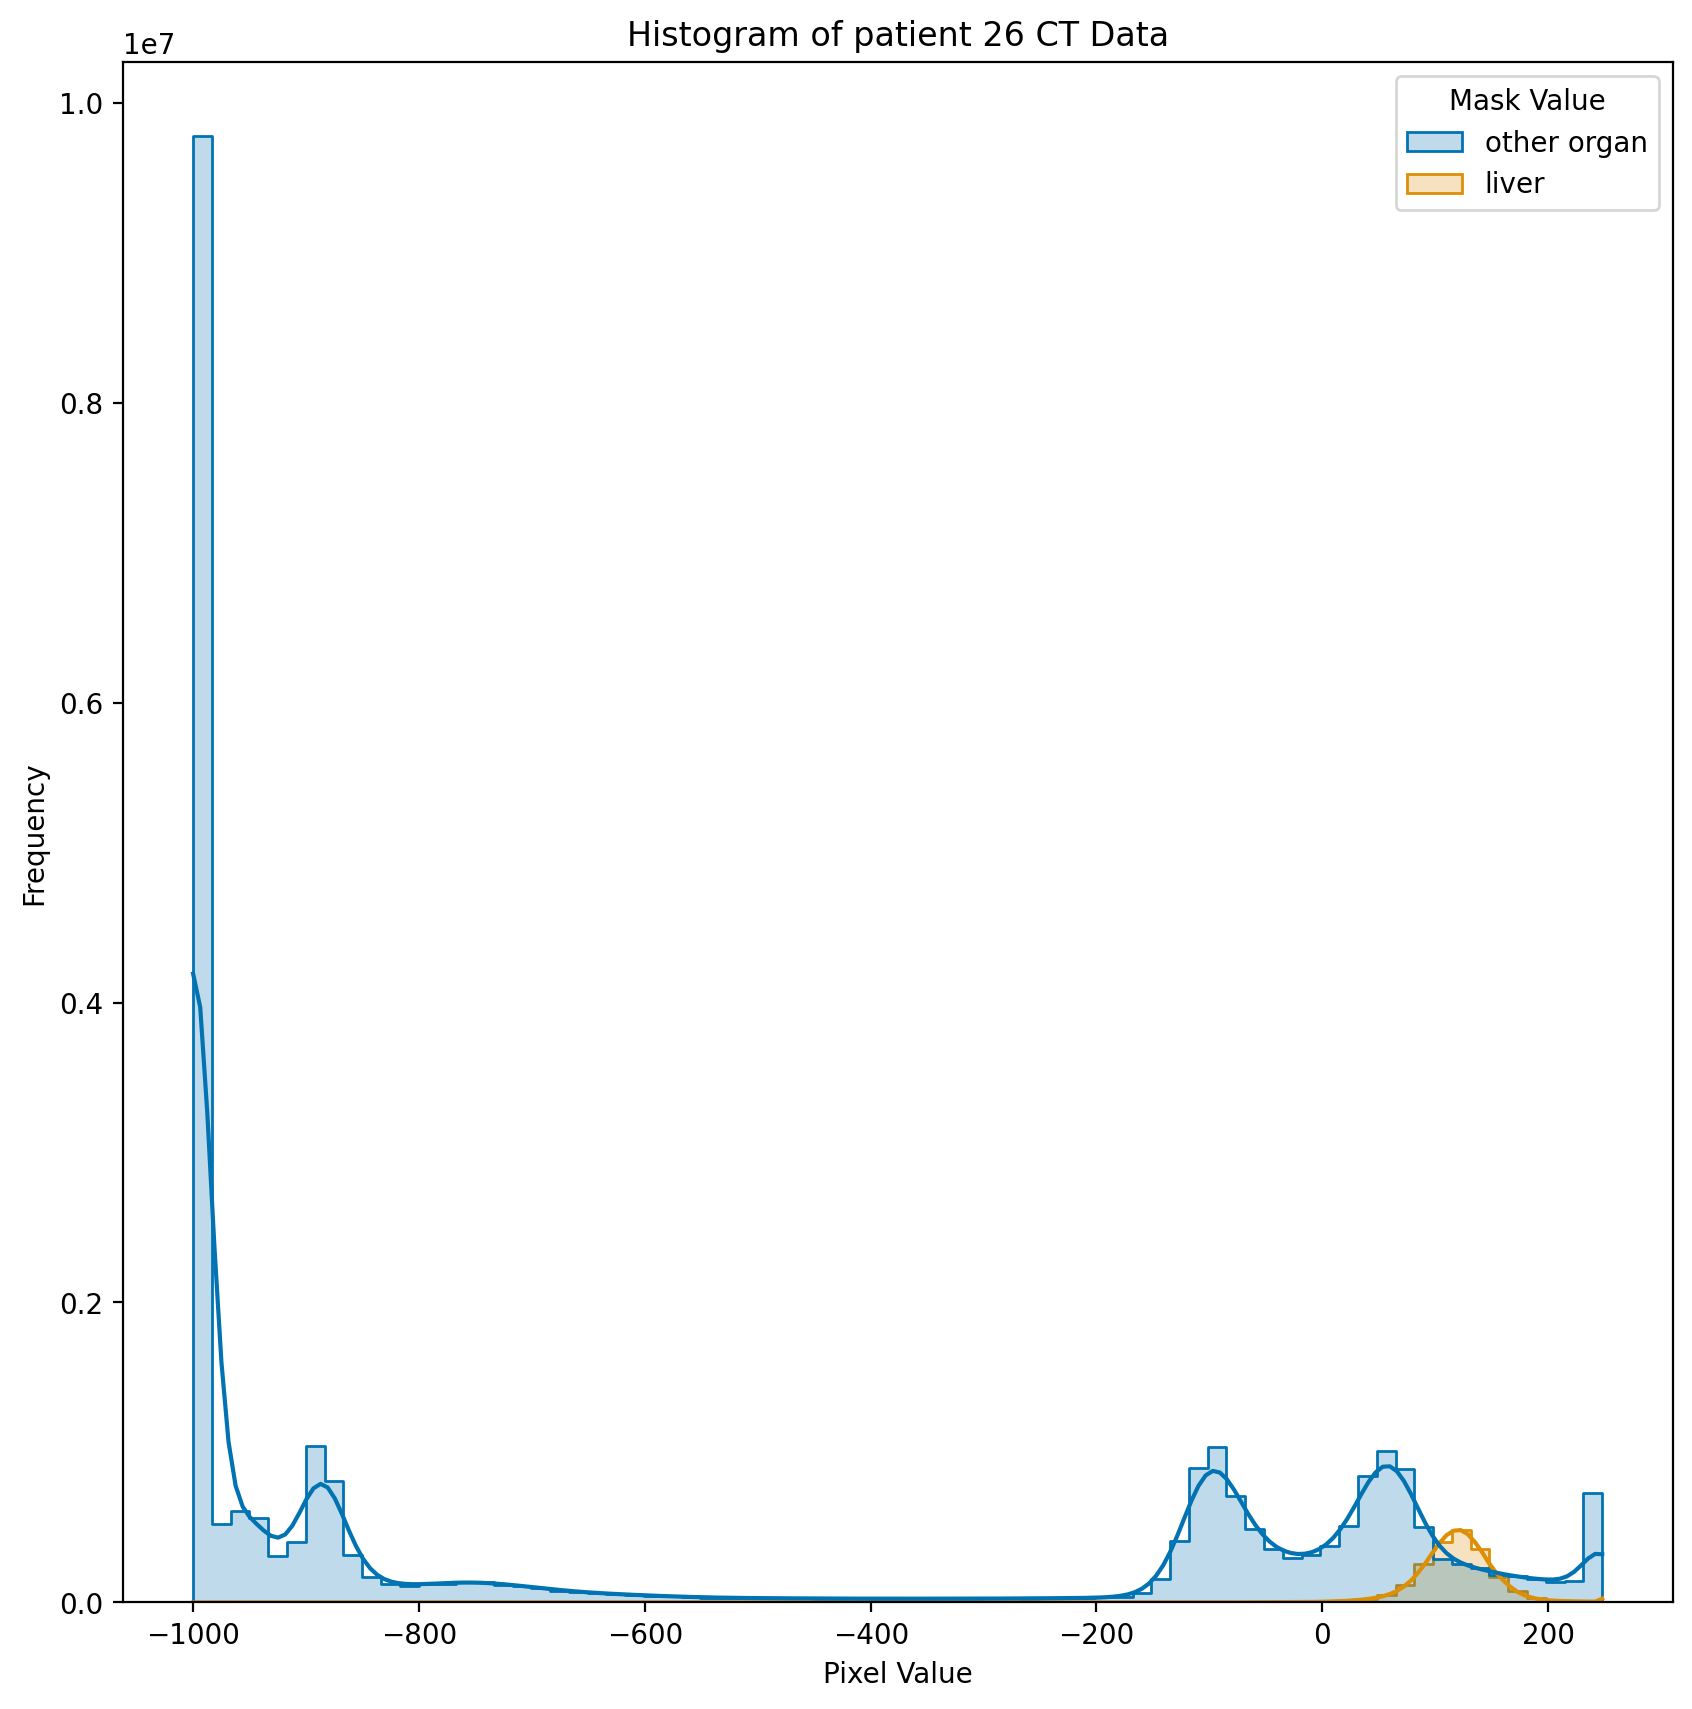

Mean:  -500.2573636707507
Median:  -776.0
Max:  248.0
Min:  -1000.0


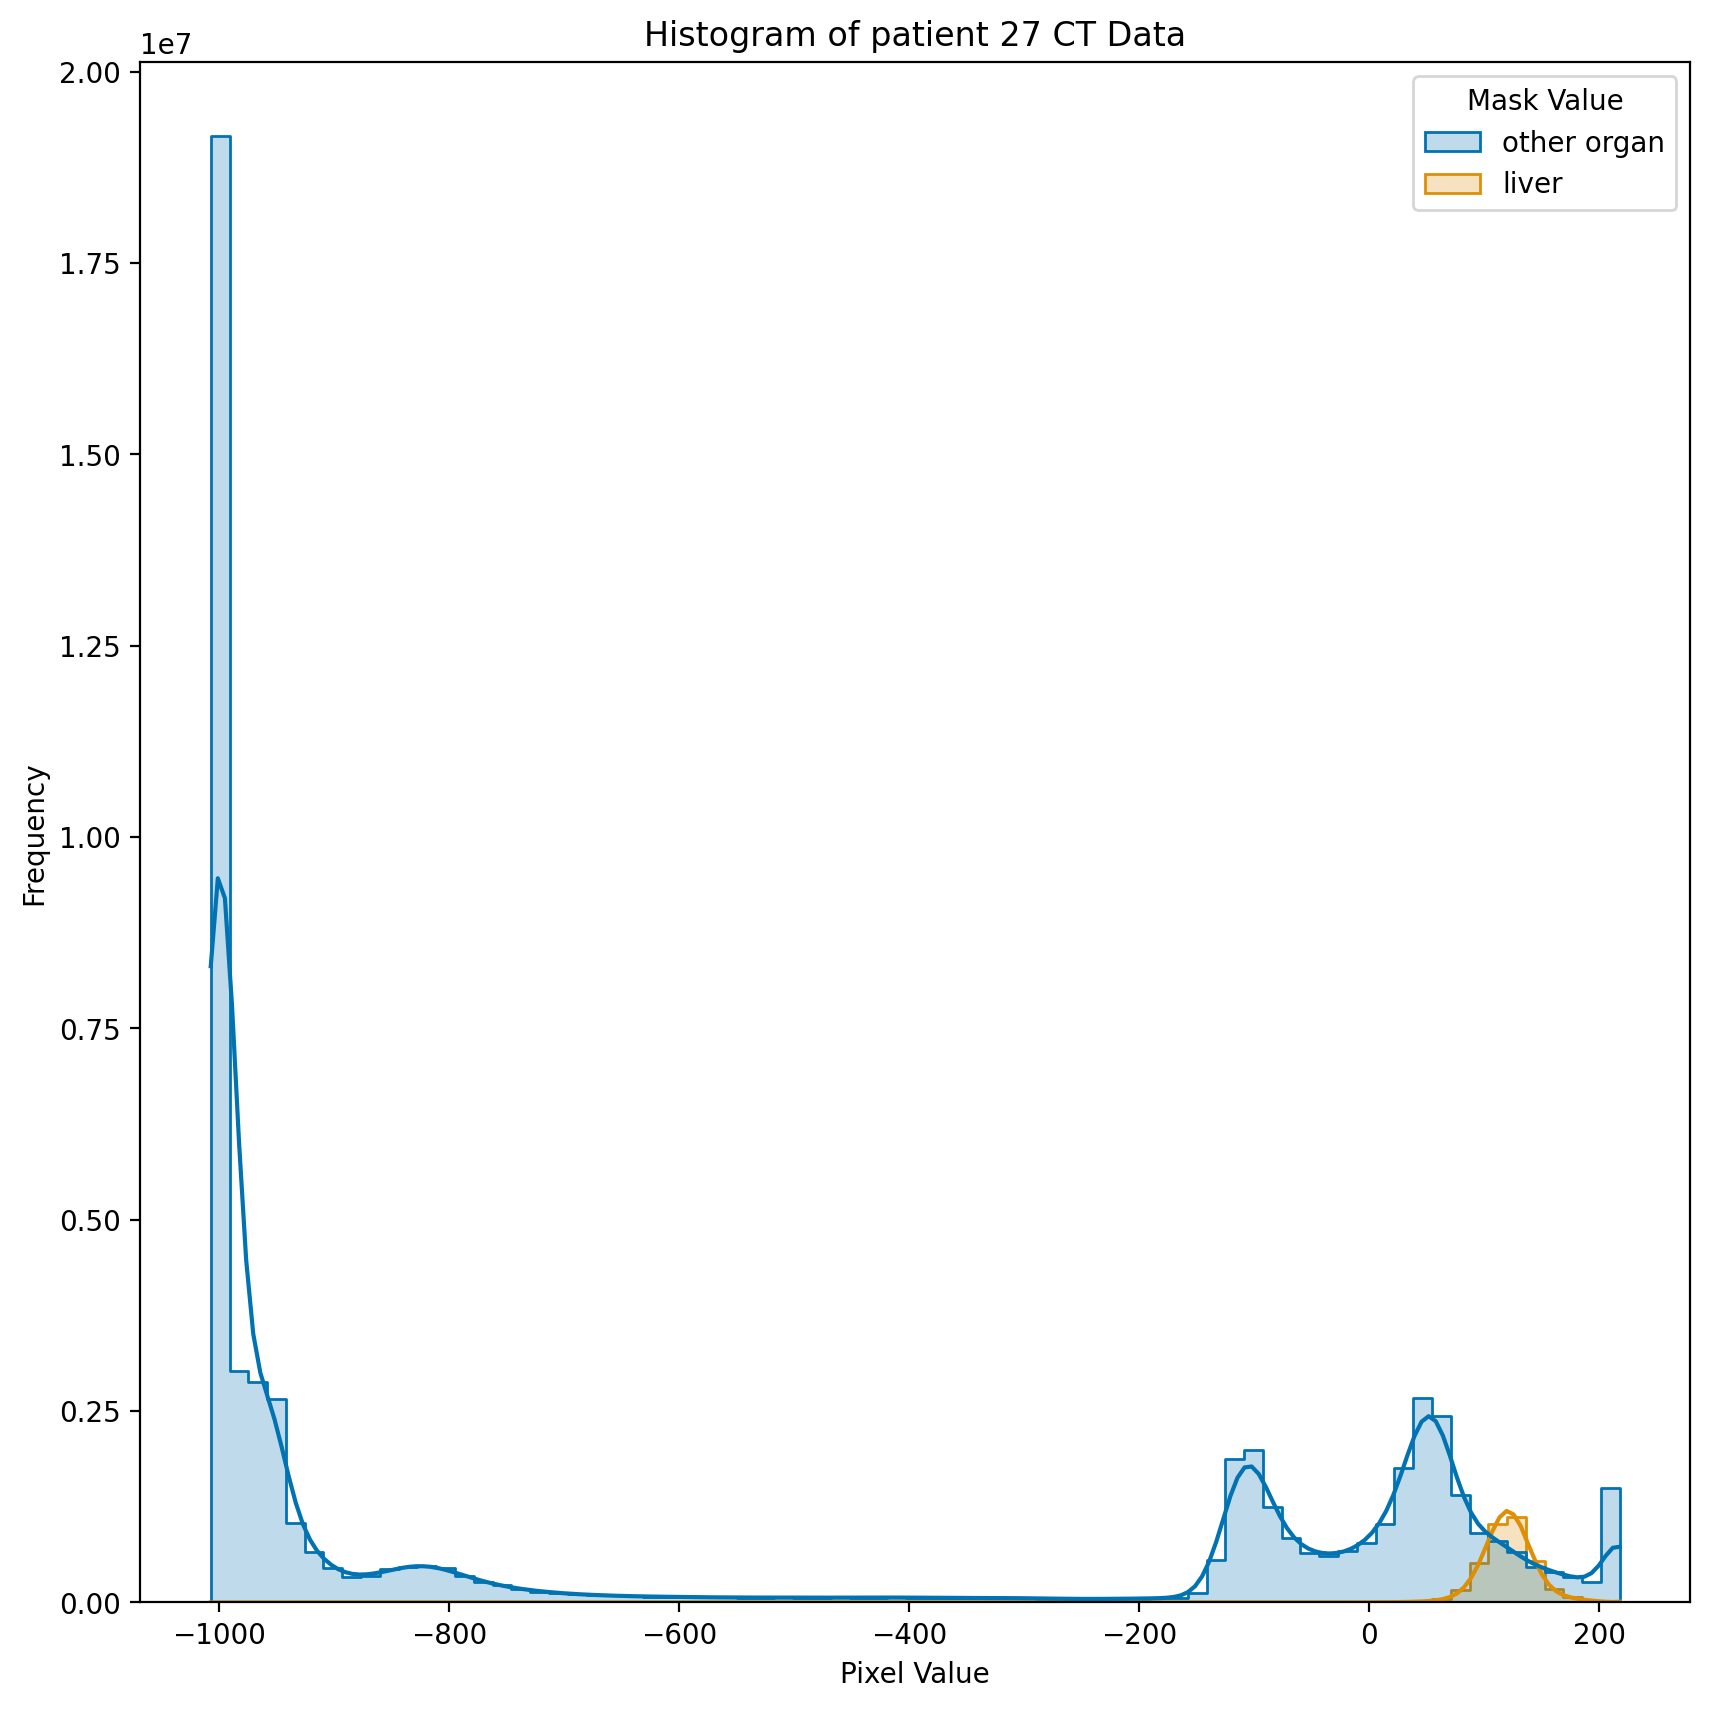

Mean:  -512.3789991268442
Median:  -819.0
Max:  218.0
Min:  -1007.0


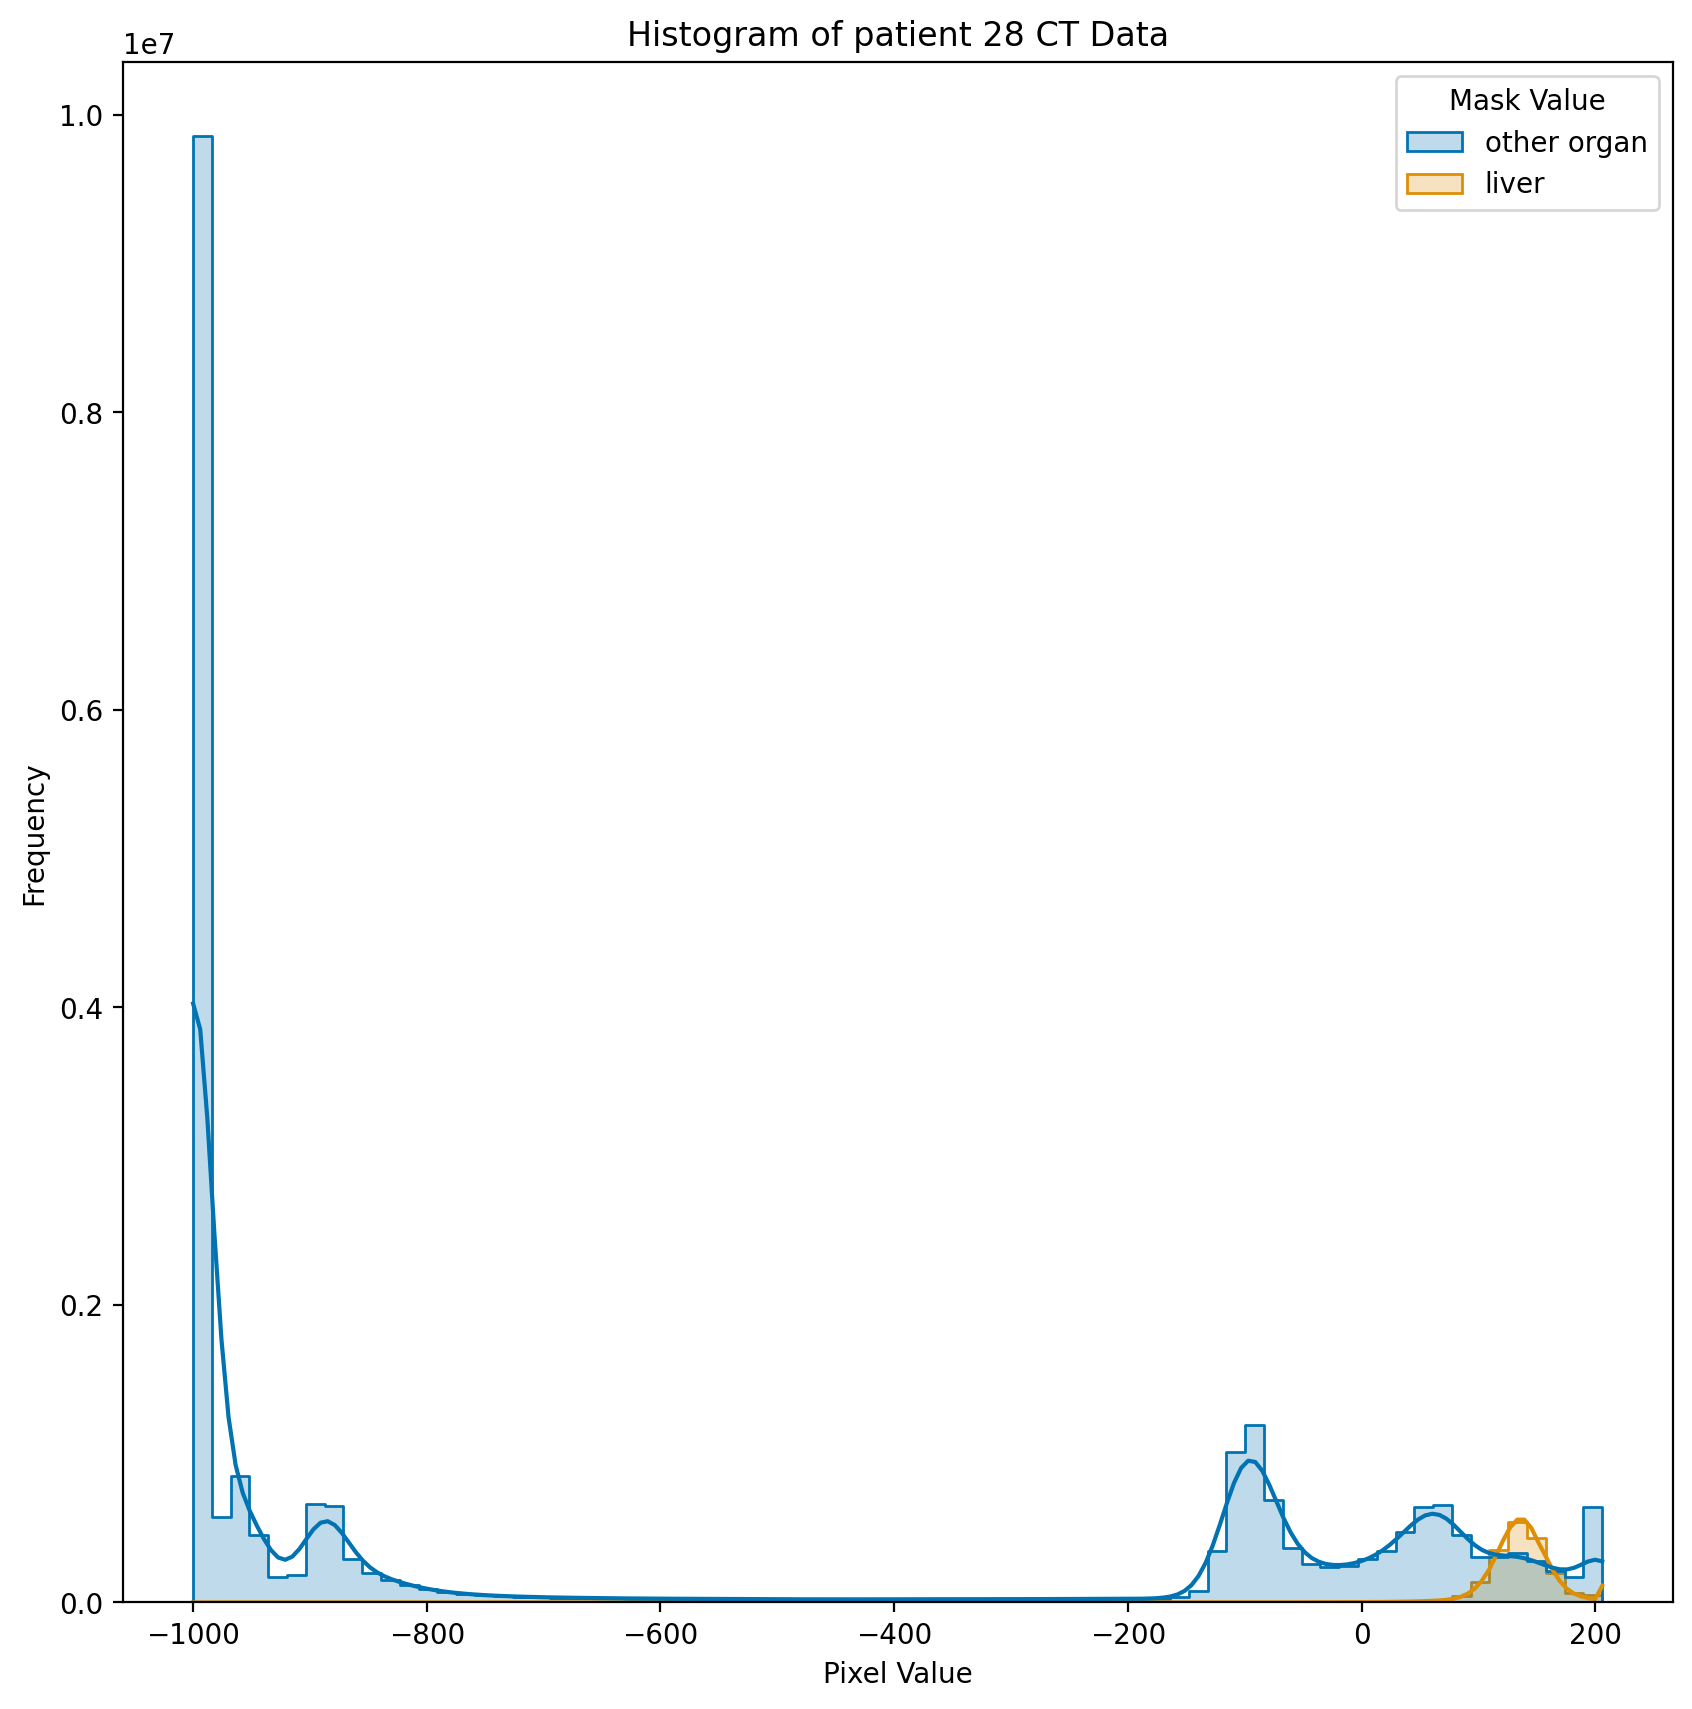

Mean:  -525.442523245718
Median:  -873.0
Max:  206.0
Min:  -1000.0


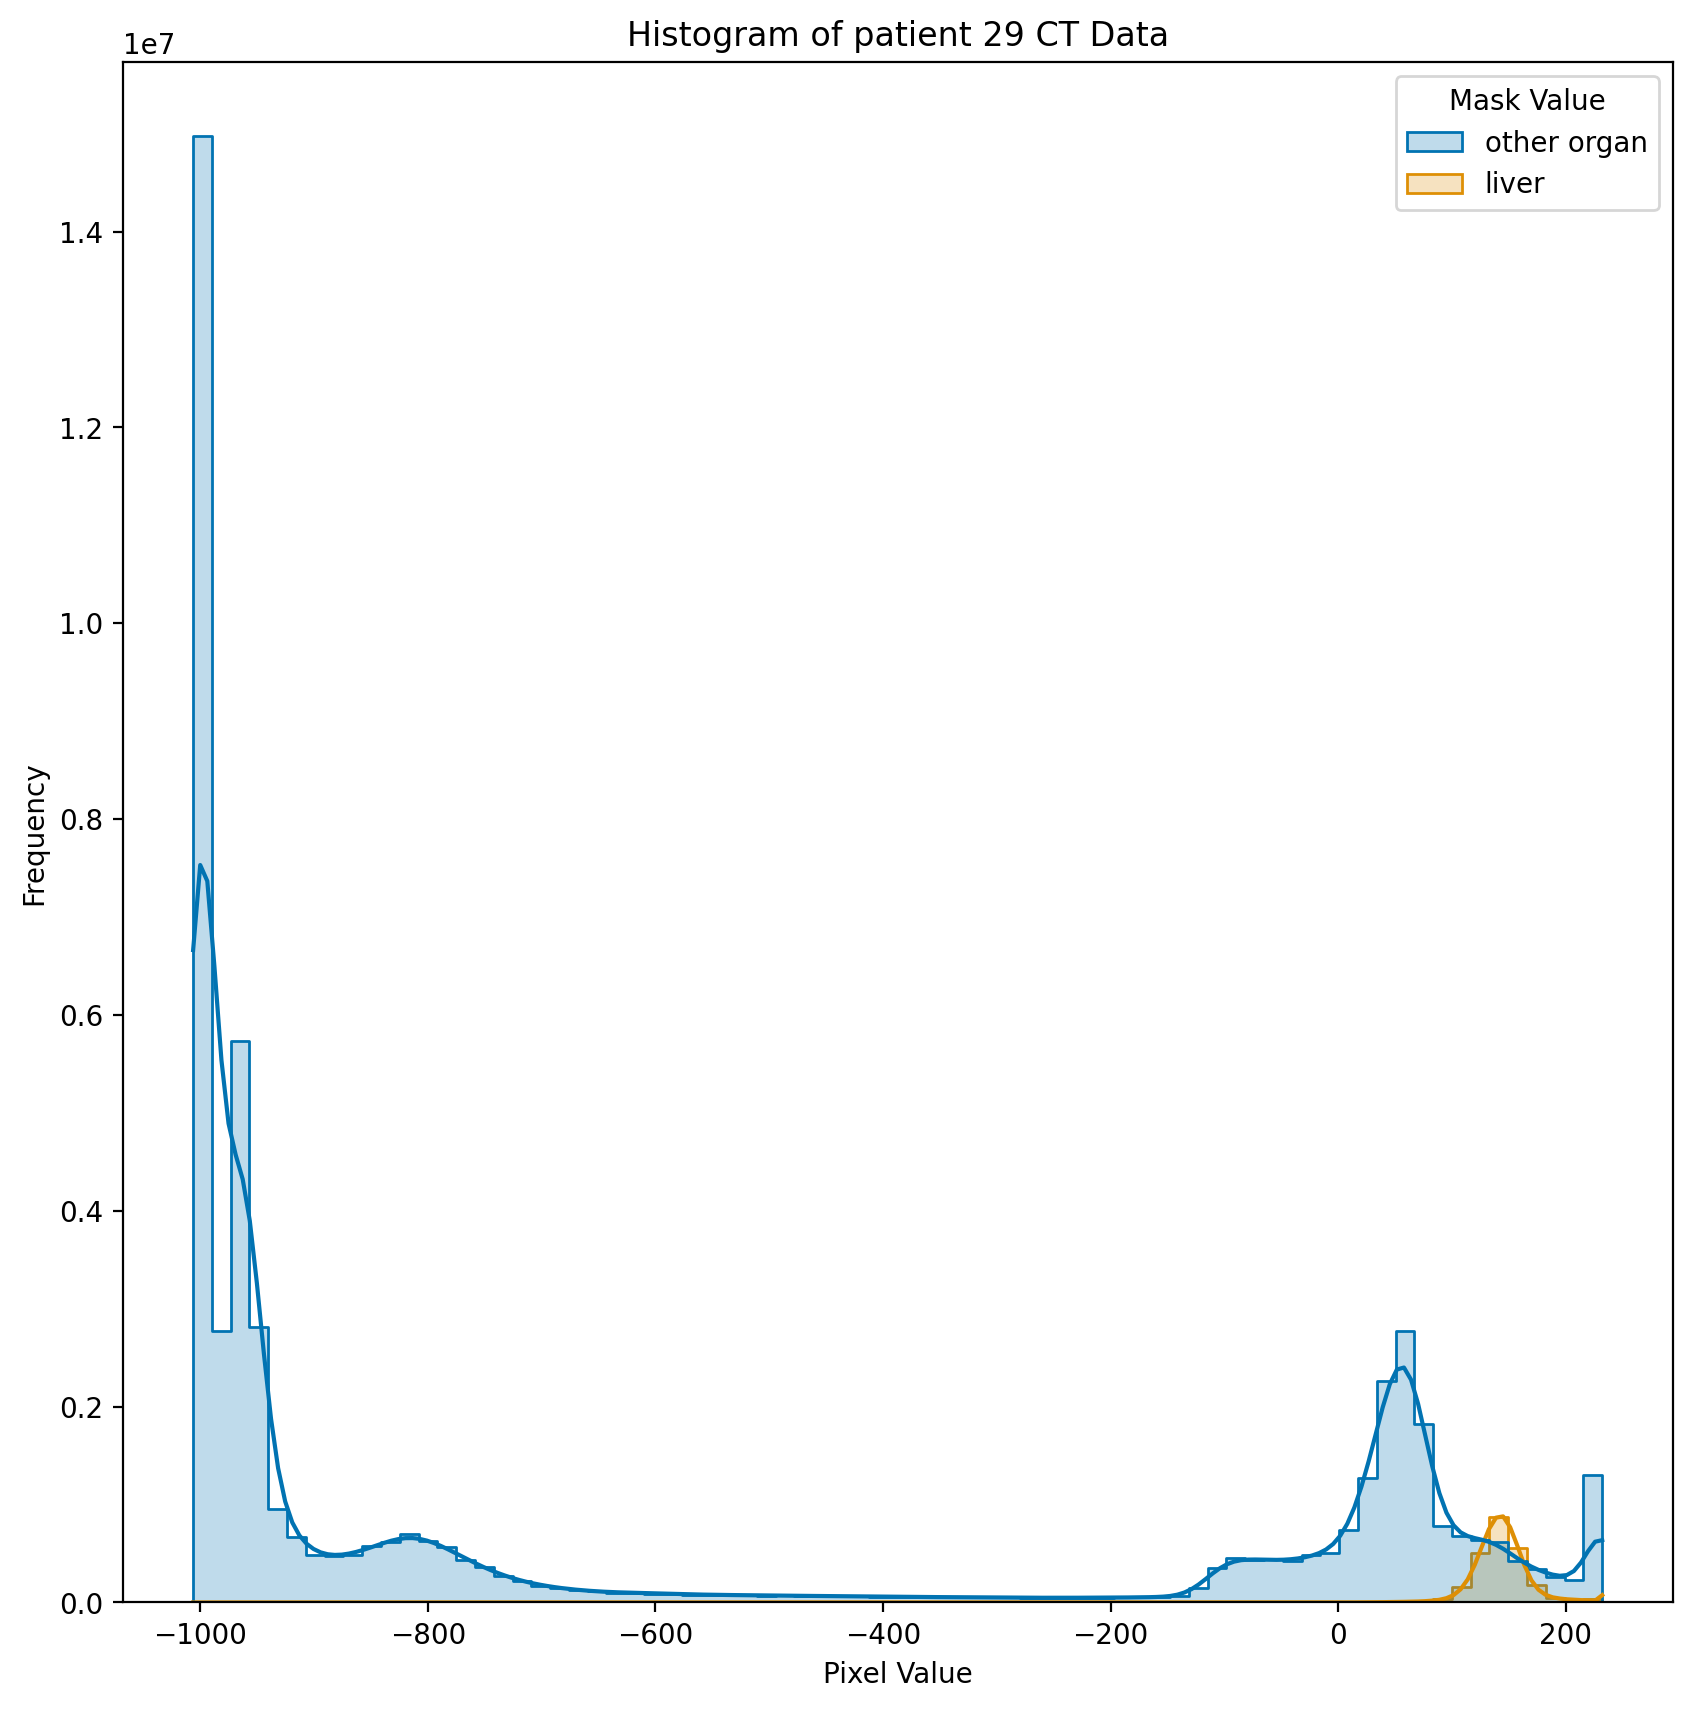

Mean:  -569.5018956549814
Median:  -903.0
Max:  232.0
Min:  -1006.0


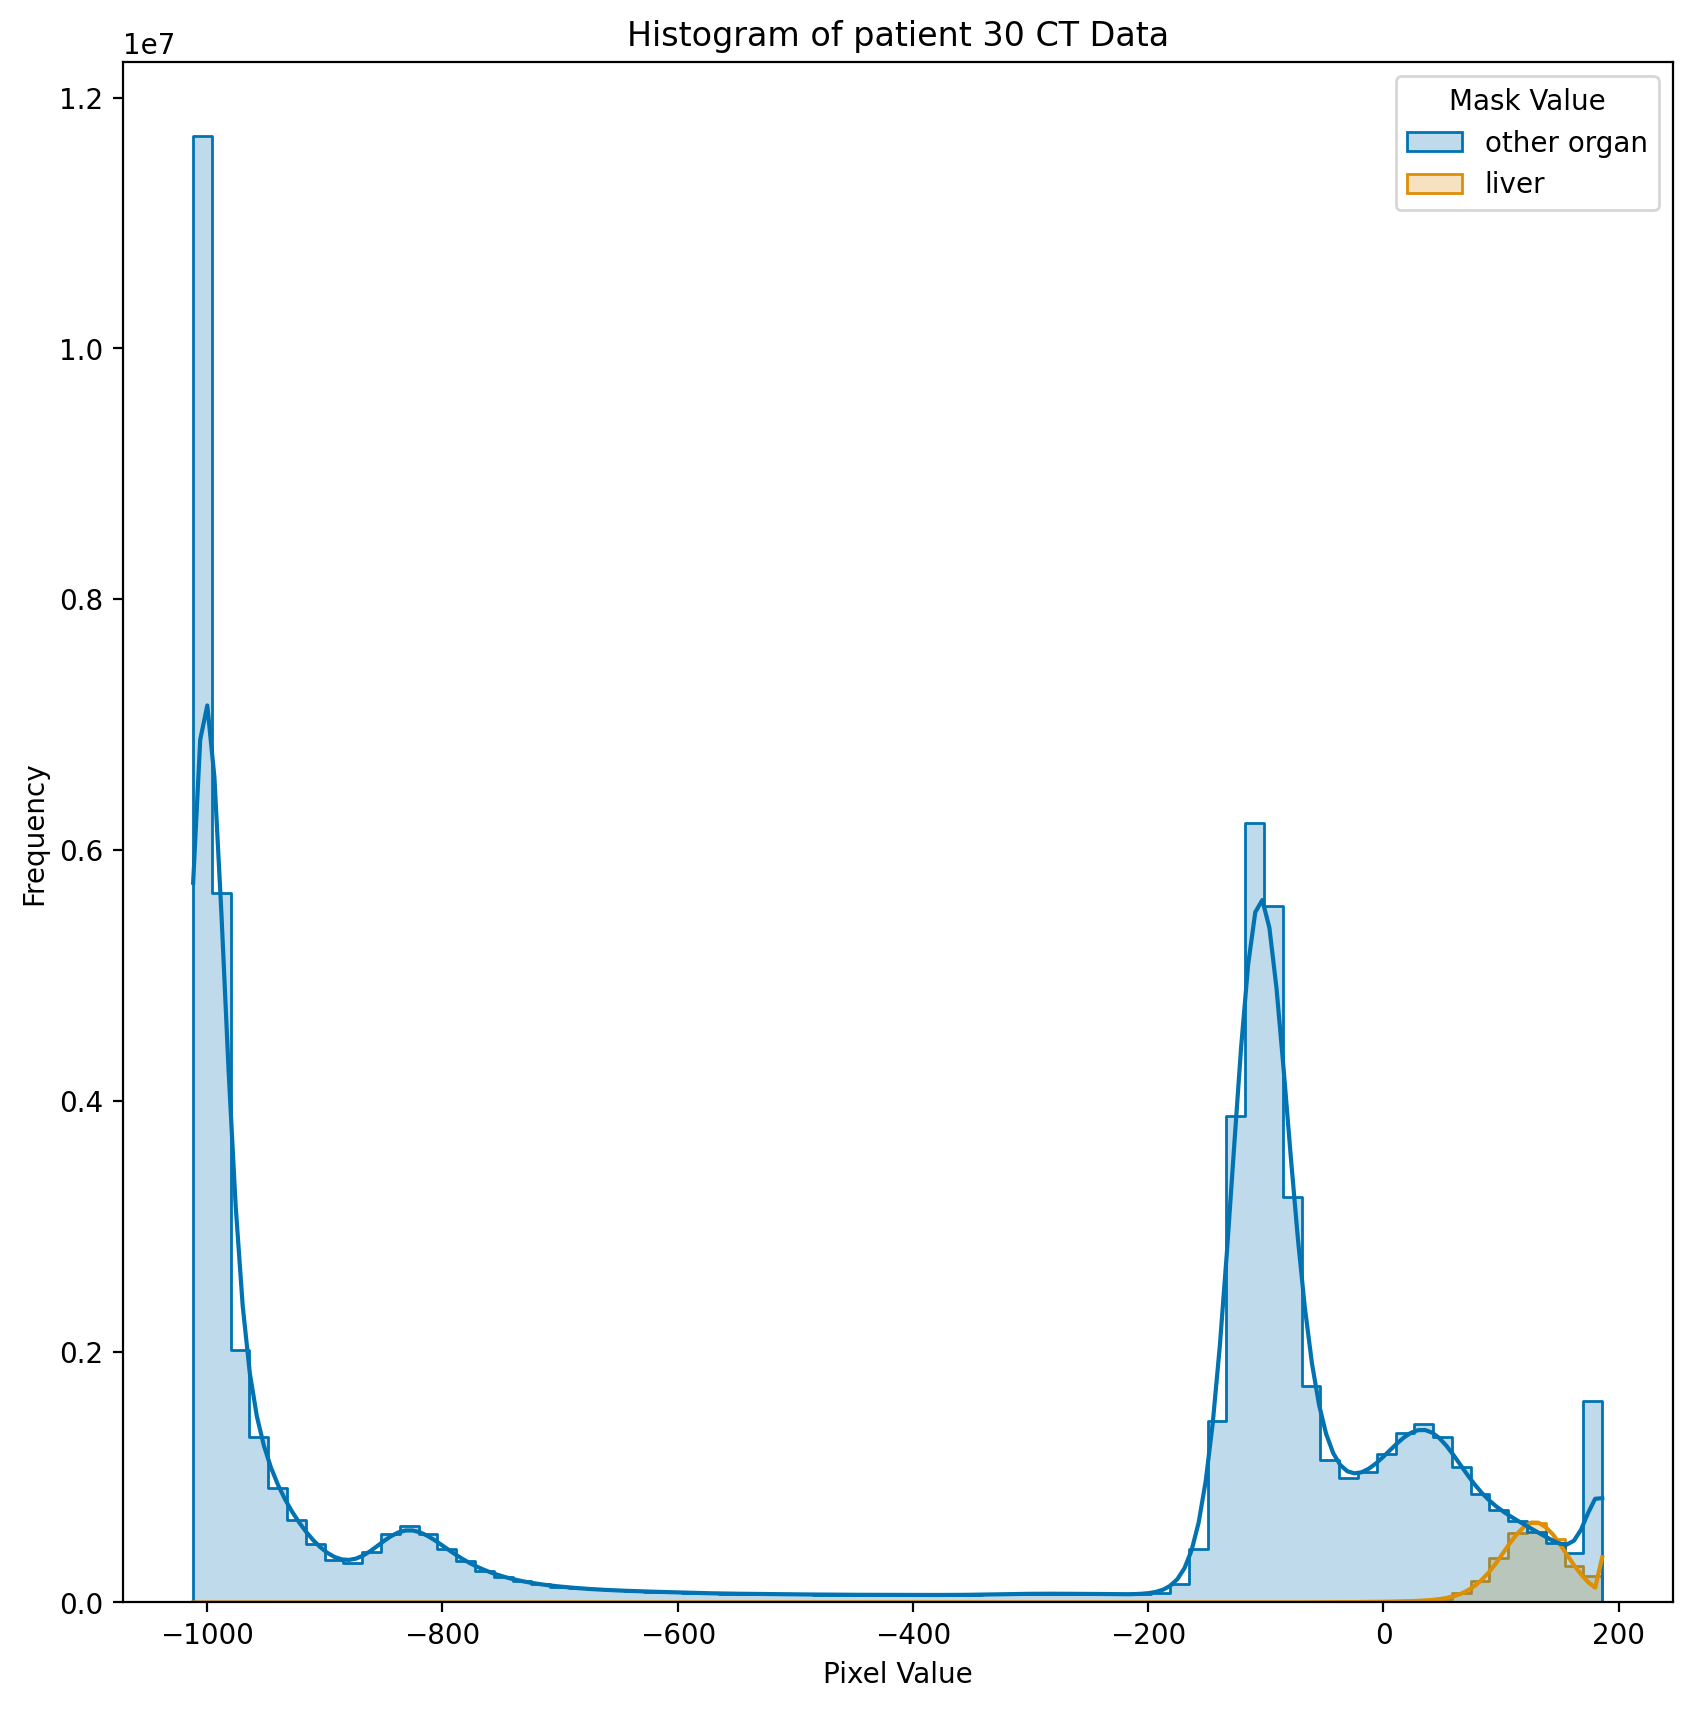

Mean:  -405.0773509032744
Median:  -119.0
Max:  186.0
Min:  -1012.0


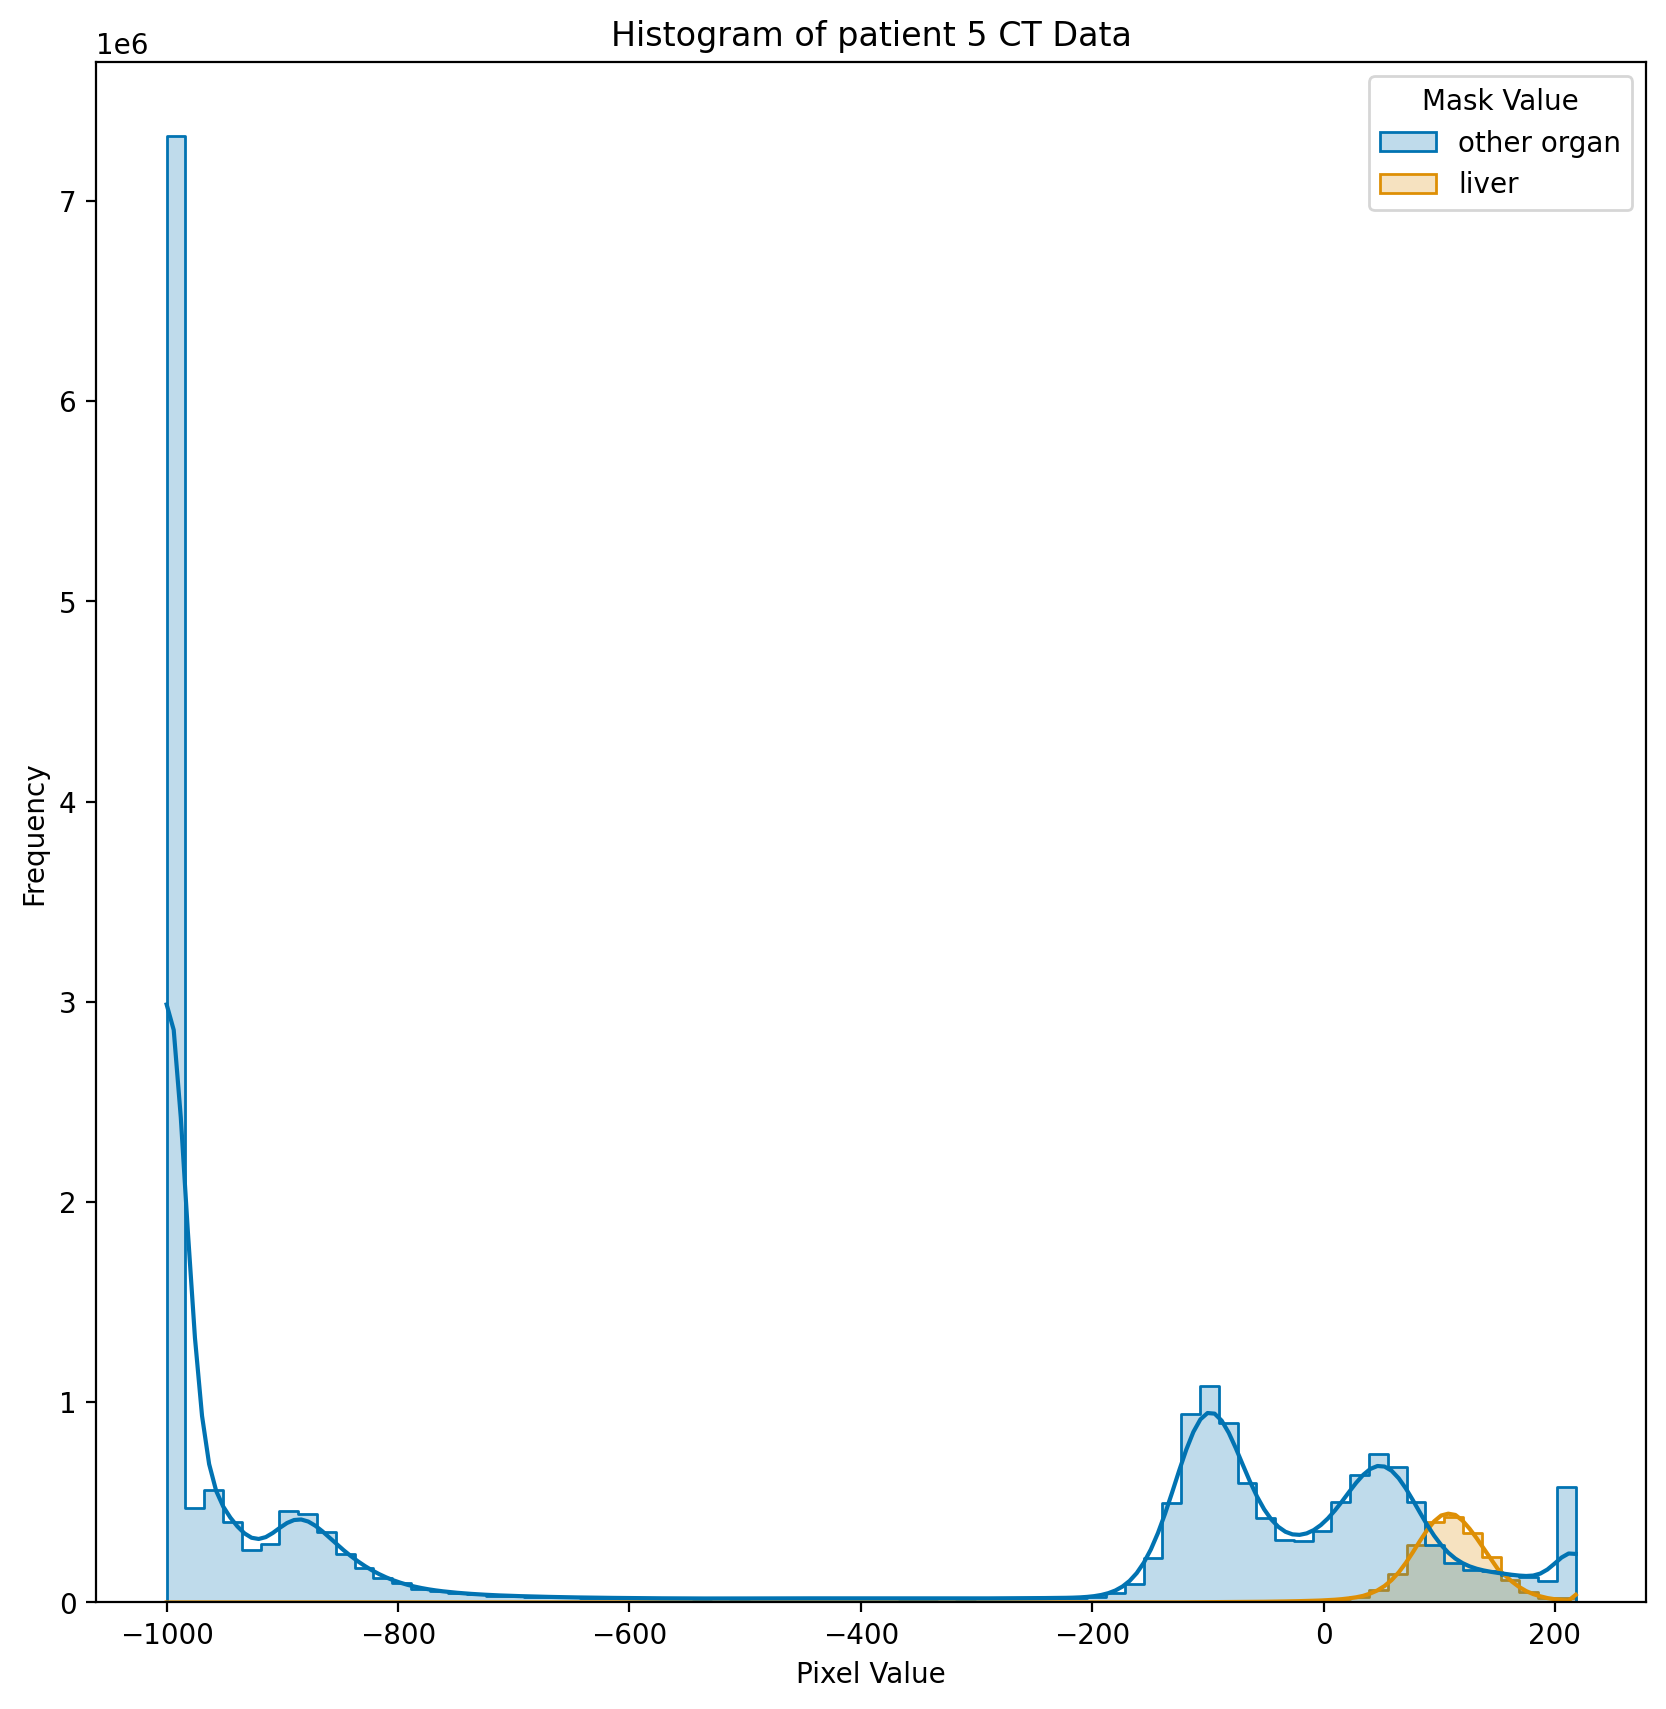

Mean:  -448.26133912739
Median:  -142.0
Max:  218.0
Min:  -1000.0


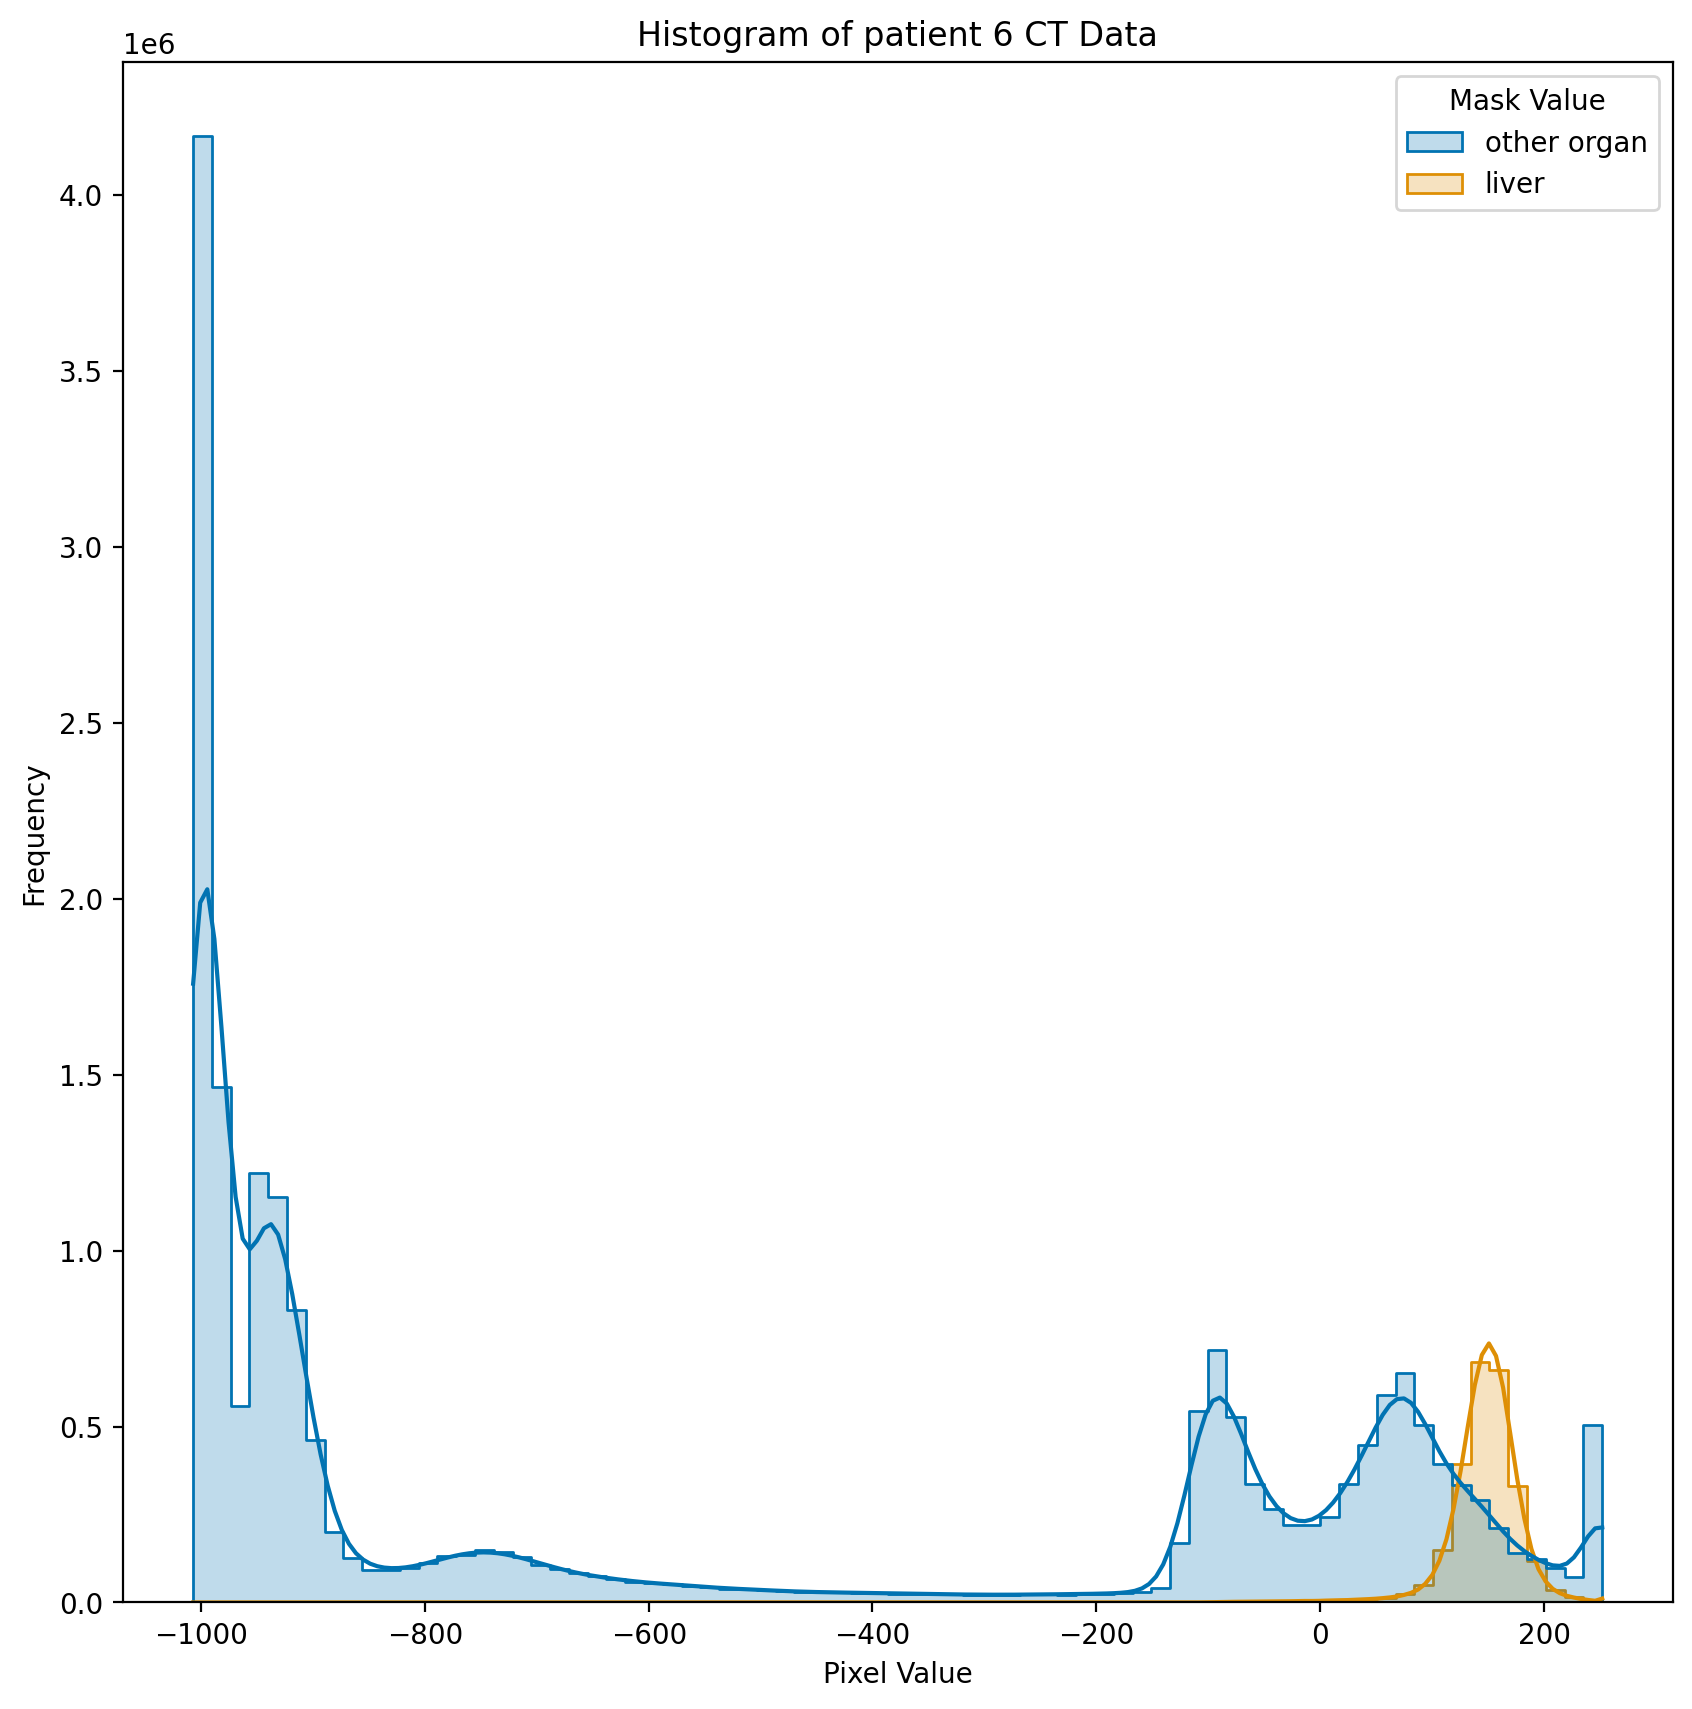

Mean:  -462.1636454408819
Median:  -658.0
Max:  252.0
Min:  -1007.0


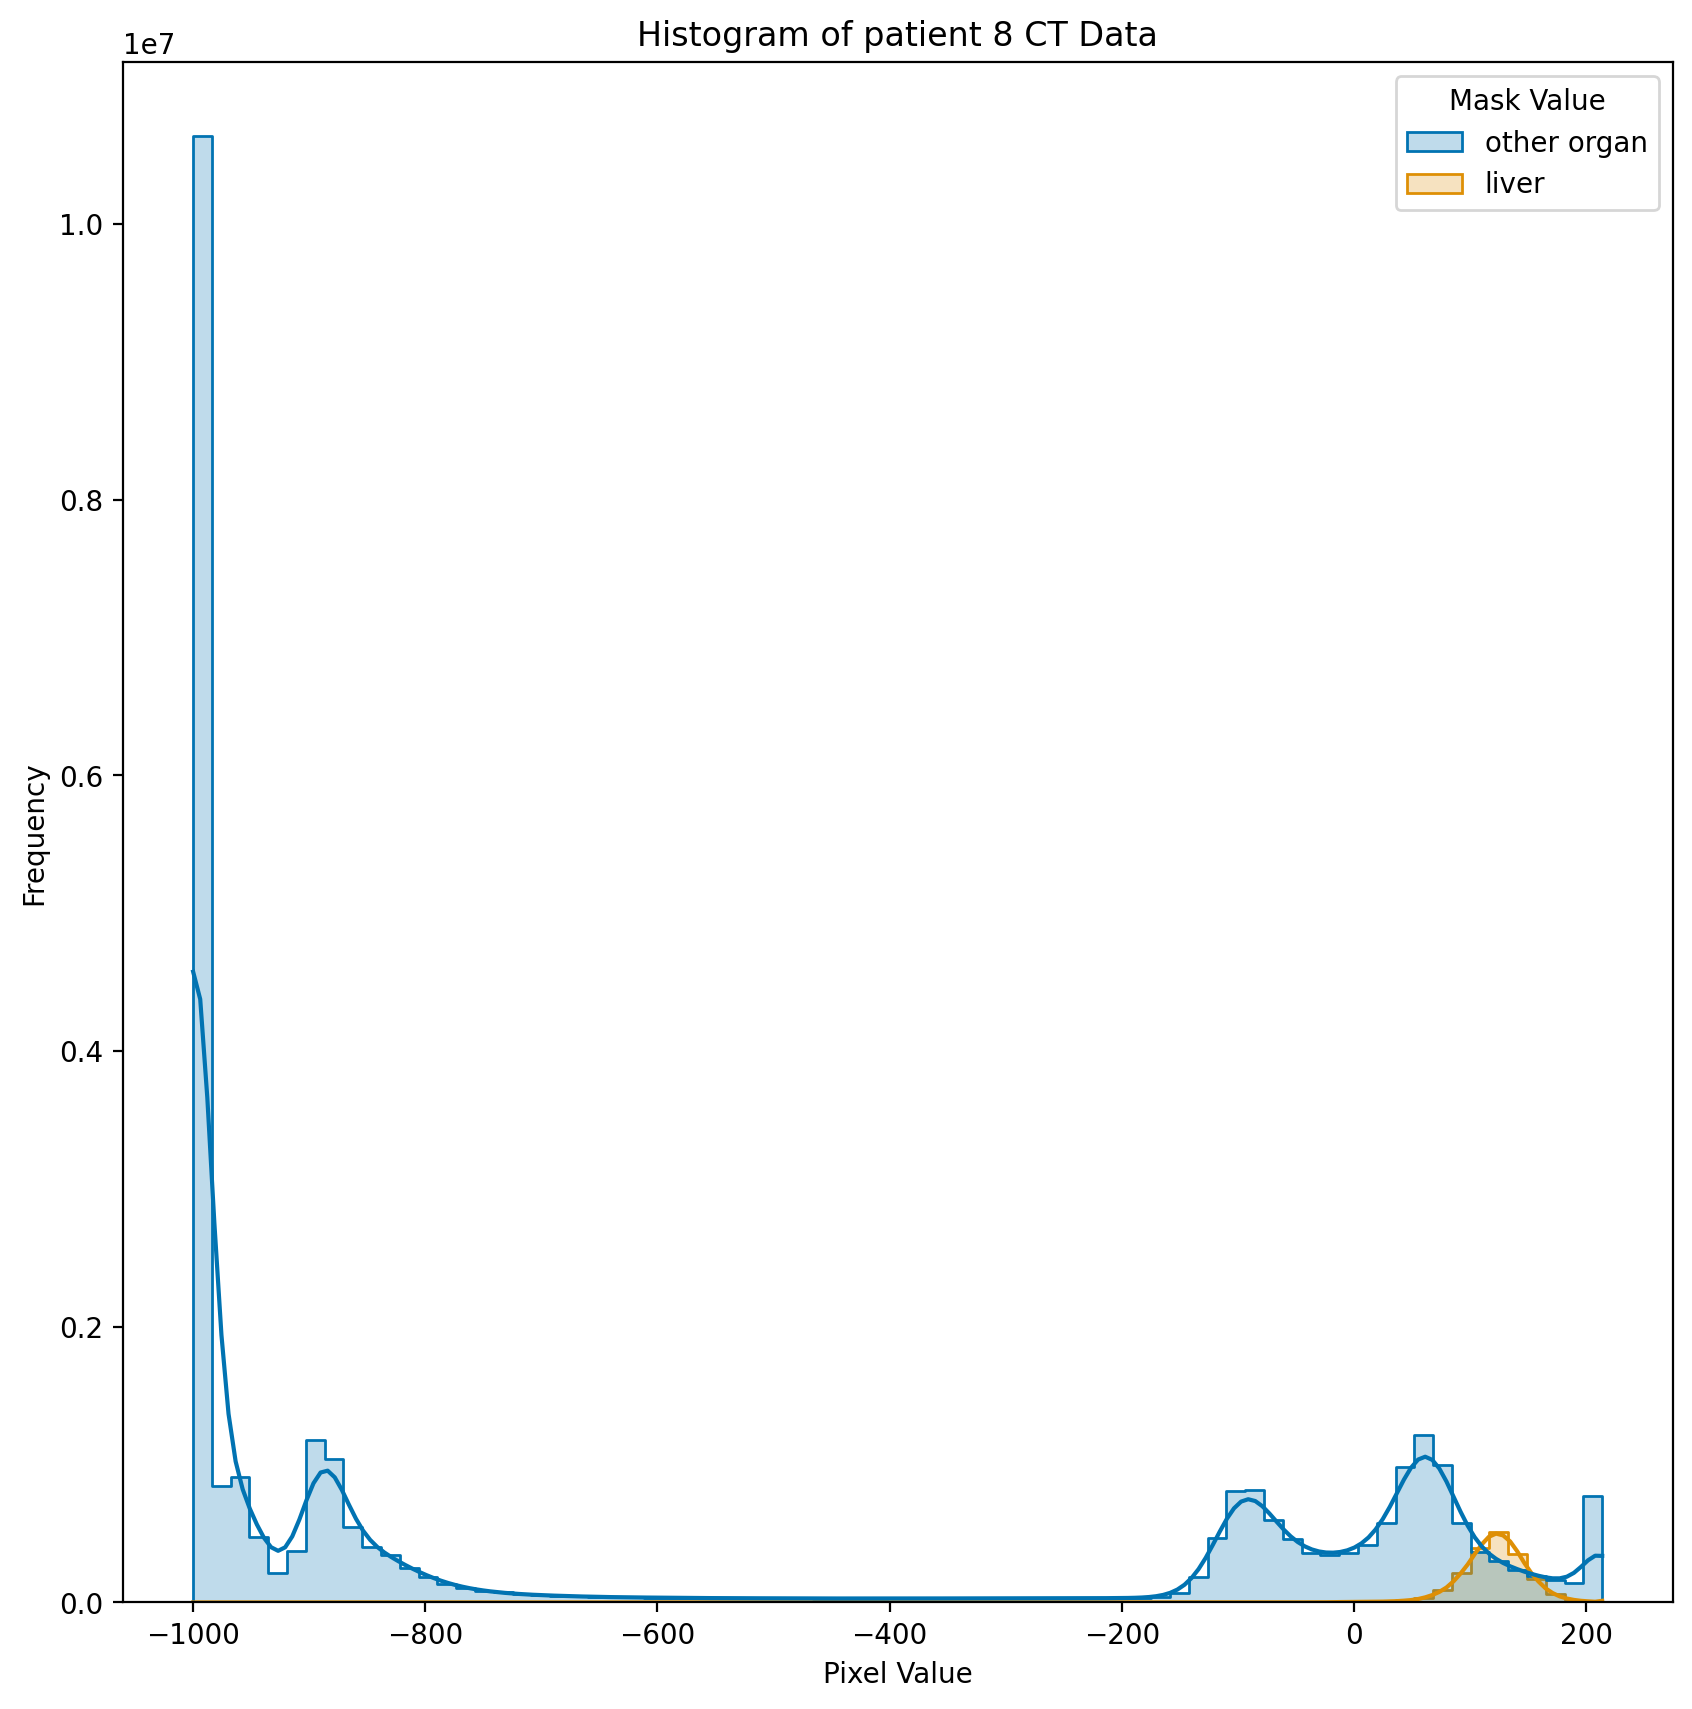

Mean:  -528.9520715853063
Median:  -858.0
Max:  214.0
Min:  -1000.0


In [4]:
root = Path(r"C:\Users\orfu\Desktop\MyData\BaiduSyncdisk\研究方向\小样本学习\数据集\CHAOS\CHAOS_Train_Sets\Train_Sets\CT")

for patient in os.listdir(root):
    plt.cla()
    dicom_folder = root / patient / "DICOM_anon"
    mask_folder = root / patient / "Ground"
    
    # load data
    ct_ndarray, ct_image = loadDcm(dicom_folder)

    mask_ndarray = laodMask(mask_folder).astype(int)
    mask_image = sitk.GetImageFromArray(mask_ndarray)
    mask_image.CopyInformation(ct_image)

    # 将三维 ndarray 转换为一维数组
    flat_array = ct_ndarray.flatten()
    mask_array = mask_ndarray.flatten()

    # 计算最高5%和最低2%的百分位数
    lower_percentile = np.percentile(flat_array, 5)
    upper_percentile = np.percentile(flat_array, 98)

    # 将最高5%和最低5%的数据转换为最高值和最低值
    filtered_array = np.where(flat_array < lower_percentile, lower_percentile, flat_array)
    filtered_array = np.where(filtered_array > upper_percentile, upper_percentile, filtered_array)

    df = pd.DataFrame({'CT Value': filtered_array, 'Mask Value': mask_array})

    # 将 mask_array 中的值映射为对应的标签
    df['Mask Value'] = df['Mask Value'].replace({0: 'other organ', 1: 'liver'})

    # 使用 Seaborn 绘制直方图
    plt.figure(figsize=(10, 10))
    # 绘制不同值的直方图
    sns.histplot(data=df, bins=75, x="CT Value", hue='Mask Value', kde=True, element="step", palette="colorblind")

    # 设置图形标题和轴标签
    plt.title(f'Histogram of patient {patient} CT Data')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # 显示图形
    %config InlineBackend.figure_format = 'retina'  # 设置图像清晰度为 retina 级别
    plt.show()

    # 计算均值
    mean_value = np.mean(filtered_array)

    # 计算中位数
    median_value = np.median(filtered_array)

    # 计算最大值
    max_value = np.max(filtered_array)

    # 计算最小值
    min_value = np.min(filtered_array)

    # 输出统计信息
    print("Mean: ", mean_value)
    print("Median: ", median_value)
    print("Max: ", max_value)
    print("Min: ", min_value)